In [41]:
import numpy as np
import torch
from PIL import Image, ImageFont, ImageDraw 
import matplotlib.pyplot as plt
import os

In [16]:
def read_A(path, i):
    path=os.path.join(path, str(i)+'_decoder.pt')
    A = torch.load(path)[1].softmax(-1).squeeze()
    num_nodes = int(np.sqrt(A.size(0)))
    A = A.view(num_nodes, num_nodes, -1).cpu().detach().numpy()
    return num_nodes, A


In [65]:
def draw_background(num_nodes, im_size=400, center_xs=[100, 300]):
    # 255, 255, 255 is white
    texts=["shape", "color", "friction", "theta", "mass", "v_0", "velocity", "position"]
    r = 0.4*im_size/(2+num_nodes)
    im = Image.new('RGB', (im_size, im_size), (255,255,255))
    draw = ImageDraw.Draw(im)
    center_ys = np.linspace(0, im_size, num_nodes+1, endpoint=False)[1:]
    for x in center_xs:
        for i in range(len(center_ys)):  
            y = center_ys[i]
            draw.ellipse((x-r, y-r, x+r, y+r), fill=(255, 255, 0))
            draw.text((x-r,y-r),texts[i], fill=(0,0,0))
    return im, draw, center_ys 


In [57]:
def draw_lines(A, draw, center_ys, center_xs=[100, 300]):
    edge = A.argmax(-1)
    for i in range(len(A)):
        for j in range(len(A[0])):
            if edge[i][j]==1:
                print(A[i][j][1])
                color = 'hsl(%d, %d%%, %d%%)' % (180, (1-A[i][j][1])*100, (1-A[i][j][1])*100)
                draw.line([(center_xs[0], center_ys[j]), (center_xs[1],center_ys[i])],\
                          width=3, fill=color)
    

0.8804715
0.82889795
0.69982076
0.77607983
0.72248304
0.751358


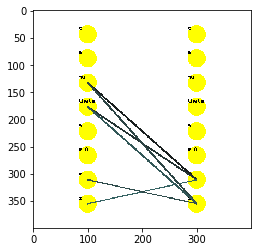

In [63]:
num_nodes, A=read_A(path, 20)
im, draw, center_ys = draw_background(8)
draw_lines(A, draw, center_ys)
plt.imshow(im)

In [23]:
# pos = 0
# images = []
# for i in range(10):
#     frame = im.copy()
#     draw = ImageDraw.Draw(frame)
#     draw.ellipse((pos, pos, 50+pos, 50+pos),
#                  'red')
#     images.append(frame)
#     pos += 10
# images[0].save('./pillow_imagedraw.gif',
#                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

array([  0.        ,  57.14285714, 114.28571429, 171.42857143,
       228.57142857, 285.71428571, 342.85714286, 400.        ])

In [68]:
folder='exp2020-08-11T13:51:41.155358_train-bs_144_suffix_causal_vel_grouped_46656'
path='logs/'+folder
images=[]
for i in np.linspace(0,200,11,dtype=int):
    num_nodes, A=read_A(path, i)
    im, draw, center_ys = draw_background(num_nodes)
    draw_lines(A, draw, center_ys)
    images.append(im)
images[0].save(folder+'_connection.gif',
                save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)

0.54270715
0.52179664
0.55619025
0.52932024
0.505581
0.564859
0.5301114
0.53756183
0.50410086
0.51199985
0.54812163
0.52524024
0.52730995
0.5191061
0.50277716
0.54168266
0.53370786
0.54583335
0.5262317
0.5042182
0.50529176
0.51121265
0.5169163
0.50210065
0.5382779
0.5069423
0.52574706
0.5120955
0.5154713
0.50942457
0.5223811
0.5002366
0.53426117
0.51594454
0.5516667
0.5062522
0.51041514
0.51895535
0.5182699
0.5196324
0.5115767
0.5194031
0.66266817
0.63130796
0.5046667
0.55031145
0.59704465
0.5892492
0.56256574
0.74011403
0.69439214
0.59637713
0.66730124
0.6343581
0.614172
0.7657453
0.71633744
0.615473
0.688552
0.65072864
0.6362235
0.7894982
0.7376776
0.63289726
0.70709944
0.6632935
0.655219
0.7990945
0.746385
0.6395879
0.7127027
0.6684248
0.6633785
0.8077179
0.7539209
0.64721
0.7204226
0.6741056
0.6712847
0.8118116
0.7576158
0.6510531
0.7232101
0.6767245
0.674432
0.81554353
0.76026785
0.6540877
0.72525525
0.67885363
0.6783459
0.81712836
0.76213443
0.65576386
0.7268157
0.6802457
0.68055

In [89]:
from models.modules_causal_vel import *
from data.AL_sampler import RandomPytorchSampler
from data.datasets import *
from data.dataset_utils import *
import argparse
from torch.utils.data import DataLoader
from utils.functions import *

parser = argparse.ArgumentParser()
parser.add_argument("-f",help="Input image, directory, or npy.")
args = parser.parse_args()
args.dims = 9
args.edge_types = 2
args.decoder_hidden = 512
args.skip_first = True
args.decoder_dropout = 0.0
args.self_loop = True
args.suffix = 'valid_causal_vel_x0s'
args.input_atoms = 6
args.variations = 4
args.train_size = None
args.temp = 0.5
args.hard = False
args.prediction_steps = 19
args.control_constraint = 1.0
args.grouped=False
args.train_bs=1
args.target_atoms =2
args.gt_A=True

args.num_atoms = args.input_atoms+args.target_atoms        
decoder = MLPDecoder_Causal(args).cuda()

off_diag = np.ones([args.num_atoms, args.num_atoms])
rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec).cuda()
rel_send = torch.FloatTensor(rel_send).cuda()


Using ground truth A and the softmax result is tensor([[[[10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
          [10.,  0.],
       

In [2]:
def denormalize(target, output, train_data):
    for i in range(target.size(1)):
        output[:,i,:,0] = ((output[:,i,:,0]+1)*(train_data.maxs[i]-train_data.mins[i]))/2+train_data.mins[i]
        target[:,i,:,0] = ((target[:,i,:,0]+1)*(train_data.maxs[i]-train_data.mins[i]))/2+train_data.mins[i]
    return target, output

In [72]:
def load_predict(args, weight_path, stop_ind=50):
    if args.grouped:
        assert args.train_bs % args.variations == 0, "Grouping training set requires args.traing-bs integer times of args.variations"

        train_data = load_one_graph_data(
            args.suffix, size=args.train_size, self_loop=args.self_loop, control=True, control_nodes=args.input_atoms, variations=args.variations)
        train_sampler = RandomPytorchSampler(train_data)
        train_data_loader = DataLoader(
            train_data, batch_size=args.train_bs, shuffle=False, sampler=train_sampler)

    else:
        train_data = load_one_graph_data(
            args.suffix, size=args.train_size, self_loop=args.self_loop, control=False)
        train_data_loader = DataLoader(
            train_data, batch_size=args.train_bs, shuffle=True)
    
    
    decoder.load_state_dict(torch.load(weight_path)[0])
    decoder.eval()  
    if not args.gt_A:
        print('loading rel_graph')
        decoder.rel_graph = torch.load(weight_path)[1].cuda()
    loss=[]
    truth = []
    pred = []
    condition =[]
    for batch_idx, all_data in enumerate(train_data_loader):
        if batch_idx<stop_ind:
            if args.grouped:
                # edge is only for calculating edge accuracy. Since we have not included that, edge is not used.
                data, which_node, edge = all_data[0].cuda(
                ), all_data[1].cuda(), all_data[2].cuda()
                output, logits, msg_hook = decoder(data, rel_rec, rel_send,
                                                   args.temp, args.hard, args.prediction_steps, [])
                control_constraint_loss = control_loss(
                    msg_hook, which_node, args.input_atoms, args.variations)*args.control_constraint
                # if batch_idx == 20:
                #     print('start3', time.time()-start3)

            else:
                data, edge = all_data[0].cuda(), all_data[1].cuda()
                output, logits, msg_hook = decoder(data, rel_rec, rel_send,
                                                   args.temp, args.hard, args.prediction_steps, [])
                control_constraint_loss = torch.zeros(1).cuda()
            print('batch_size', data.size(0))
            target = data[:, :, 1:, :] 
            loss_nll = nll_gaussian(output[:, -2:, :, :], target[:, -2:, :, :], 5e-5)
            print('Nll', loss_nll)
            loss.append(loss_nll.item())
            
            target, output = denormalize(target, output, train_data)
            print('Setup [shapes,colors,mus,thetas,masses,v0s]', batch_idx, target[0,:-2,0,0])
            print('Velocity',batch_idx, target[0,-2,:,0], '\n',output[0,-2,:,0])
            print('Position',batch_idx, target[0,-1,:,0], '\n',output[0,-1,:,0])
            condition.append(target[:,:-2,0,0])
            truth.append(target)
            pred.append(output)
        else:
            print('Avg nll loss', np.mean(loss))
            return loss, truth, pred, condition

In [4]:
def extra_inter(paths, ratios=[0,10,20,40,60]):
    record=np.zeros((len(paths), len(ratios)-1))
    for i in range(1, len(ratios)):
        args.suffix='valid_causal_vel_x0s_extrapolation_'+str(ratios[i-1])+'_'+str(ratios[i])+'%'
        for p in range(len(paths)):
            loss, truth, pred, condition = load_predict(args, paths[p])
            record[p][i-1] = np.mean(loss)

    record_inter=[]        
    args.suffix='valid_causal_vel_x0s_interpolation'
    for p in paths:
        loss, truth, pred, condition = load_predict(args, p)
        record_inter.append(np.mean(loss))

    return record, record_inter
    

In [12]:
p='logs/exp2020-08-17T19:03:34.063203_train-bs_128_suffix_causal_vel_x0s_val-suffix_causal_vel_interpolation_input-atoms_6_dims_9_decoder-hidden_512_gt-A_comment_A_fc/best_decoder.pt'
extra_inter([p])

loading valid_causal_vel_x0s_extrapolation_0_10%
batch_size 1
Nll tensor(73778.6562, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([2.0000e+00, 5.0000e+00, 5.0000e-03, 1.2600e+00, 1.0700e+01, 2.1000e+01],
       device='cuda:0')
Velocity 0 tensor([  9.3155,  18.6310,  27.9465,  37.2620,  46.5775,  55.8930,  65.2085,
         74.5240,  83.8395,  93.1550, 102.4705, 111.7860, 121.1015, 130.4170,
        139.7325, 149.0480, 158.3635, 167.6790], device='cuda:0') 
 tensor([ 0.2402,  1.0392,  2.4868,  4.8836,  8.2195, 12.6219, 17.8679, 23.6589,
        29.6038, 35.3142, 40.5410, 45.1833, 49.2093, 52.7071, 55.7151, 58.3384,
        60.6785, 62.7920], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([  25.6577,   39.6310,   62.9197,   95.5240,  137.4437,  188.6790,
         249.2297,  319.0960,  398.2777,  486.7750,  584.5878,  691.7161,
         808.1598,  933.9191, 1068.9938, 1213.3840, 1367.0897, 1530.1111],
       device='cuda:0') 

batch_size 1
Nll tensor(43798.4727, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([1.0000, 7.0000, 0.6100, 0.5000, 1.5000, 2.0000], device='cuda:0')
Velocity 8 tensor([-0.5478, -1.0956, -1.6435, -2.1913, -2.7391, -3.2869, -3.8347, -4.3825,
        -4.9304, -5.4782, -6.0260, -6.5738, -7.1216, -7.6695, -8.2173, -8.7651,
        -9.3129, -9.8607], device='cuda:0') 
 tensor([ 1.8927,  4.0358,  6.4495,  9.1306, 12.1768, 15.6247, 19.4902, 23.7343,
        28.2965, 33.1176, 38.1356, 43.2703, 48.4785, 53.7508, 59.0845, 64.4337,
        69.7893, 75.0997], device='cuda:0', grad_fn=<SelectBackward>)
Position 8 tensor([  1.7261,   0.9044,  -0.4652,  -2.3825,  -4.8477,  -7.8607, -11.4215,
        -15.5302, -20.1867, -25.3909, -31.1430, -37.4429, -44.2906, -51.6862,
        -59.6296, -68.1207, -77.1598, -86.7466], device='cuda:0') 
 tensor([ 10.6365,  21.4194,  34.2178,  49.6358,  68.0637,  89.8376, 115.1930,
        144.1332, 175.1322, 206.6123, 237.3

batch_size 1
Nll tensor(48991.3672, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([2.0000, 7.0000, 0.6000, 1.2600, 1.7000, 1.5000], device='cuda:0')
Velocity 15 tensor([  7.5323,  15.0646,  22.5968,  30.1291,  37.6614,  45.1937,  52.7260,
         60.2583,  67.7905,  75.3228,  82.8551,  90.3874,  97.9197, 105.4520,
        112.9842, 120.5165, 128.0488, 135.5811], device='cuda:0') 
 tensor([  1.5274,   3.7209,   6.8475,  11.2124,  17.8464,  27.1363,  39.5132,
         55.4534,  73.8681,  93.8591, 114.5015, 134.7190, 153.8145, 171.2494,
        186.2320, 198.9681, 209.8405, 219.0443], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 15 tensor([   5.2661,   16.5646,   35.3953,   61.7583,   95.6535,  137.0811,
         186.0409,  242.5330,  306.5574,  378.1141,  457.2031,  543.8243,
         637.9779,  739.6637,  848.8818,  965.6321, 1089.9148, 1221.7296],
       device='cuda:0') 
 tensor([  1.1887,   6.3728,  16.9036,  36.1039,  6

batch_size 1
Nll tensor(17281.8027, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 29 tensor([1.0000, 7.0000, 0.0000, 0.5000, 1.7000, 1.5000], device='cuda:0')
Velocity 29 tensor([ 4.6984,  9.3967, 14.0951, 18.7935, 23.4919, 28.1902, 32.8886, 37.5870,
        42.2853, 46.9837, 51.6821, 56.3804, 61.0788, 65.7772, 70.4756, 75.1739,
        79.8723, 84.5707], device='cuda:0') 
 tensor([ 0.9017,  2.1089,  3.7755,  5.9546,  8.6635, 12.0172, 15.9692, 20.2922,
        24.6639, 28.8341, 32.6959, 36.2371, 39.5352, 42.5825, 45.4005, 48.0845,
        50.6650, 53.1659], device='cuda:0', grad_fn=<SelectBackward>)
Position 29 tensor([  3.8492,  10.8967,  22.6426,  39.0870,  60.2296,  86.0707, 116.6101,
        151.8478, 191.7840, 236.4185, 285.7514, 339.7826, 398.5123, 461.9403,
        530.0667, 602.8915, 680.4146, 762.6360], device='cuda:0') 
 tensor([ 16.4666,  32.3203,  49.2887,  67.3509,  86.4101, 106.3580, 127.1186,
        148.6672, 170.9941, 194.0265, 21

Setup [shapes,colors,mus,thetas,masses,v0s] 36 tensor([10.0000,  5.0000,  0.0000,  1.2600,  1.7000,  2.0000], device='cuda:0')
Velocity 36 tensor([  9.3305,  18.6610,  27.9915,  37.3219,  46.6524,  55.9829,  65.3134,
         74.6439,  83.9744,  93.3049, 102.6353, 111.9658, 121.2963, 130.6268,
        139.9573, 149.2878, 158.6183, 167.9487], device='cuda:0') 
 tensor([ 0.7360,  1.7313,  2.9511,  4.3831,  6.0370,  7.8848,  9.8849, 11.9986,
        14.1859, 16.4070, 18.6162, 20.7956, 22.9623, 25.1141, 27.2504, 29.3708,
        31.4768, 33.5765], device='cuda:0', grad_fn=<SelectBackward>)
Position 36 tensor([   6.6652,   20.6610,   43.9872,   76.6439,  118.6310,  169.9487,
         230.5969,  300.5756,  379.8847,  468.5243,  566.4944,  673.7950,
         790.4260,  916.3876, 1051.6796, 1196.3021, 1350.2551, 1513.5387],
       device='cuda:0') 
 tensor([ 10.8243,  21.3194,  33.5256,  47.4756,  63.8390,  83.2154, 104.9795,
        128.4918, 153.2050, 178.6828, 204.2989, 229.4011, 253.6566, 

batch_size 1
Nll tensor(29412.4473, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 3.0000,  3.0000,  0.6200,  0.3800, 11.5000, 23.0000], device='cuda:0')
Velocity 0 tensor([ -2.0075,  -4.0151,  -6.0226,  -8.0302, -10.0377, -12.0453, -14.0528,
        -16.0604, -18.0679, -20.0755, -22.0830, -24.0905, -26.0981, -28.1056,
        -30.1132, -32.1207, -34.1283, -36.1358], device='cuda:0') 
 tensor([-0.7594, -1.0078, -0.8074, -0.2643,  0.6044,  1.7320,  3.0548,  4.5347,
         6.1220,  7.7856,  9.5042, 11.2488, 12.9983, 14.7350, 16.4496, 18.1355,
        19.7851, 21.4015], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([  21.9962,   18.9849,   13.9660,    6.9397,   -2.0943,  -13.1358,
         -26.1849,  -41.2415,  -58.3056,  -77.3773,  -98.4565, -121.5433,
        -146.6376, -173.7395, -202.8489, -233.9658, -267.0903, -302.2224],
       device='cuda:0') 
 tensor([ 19.9726,  20.7563,  25.0157,  32.2790,  42.1165,  53.9920,  67.

batch_size 1
Nll tensor(96809.7422, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([ 1.0000,  3.0000,  0.6600,  1.3600, 11.5000,  0.0000], device='cuda:0')
Velocity 7 tensor([  8.2297,  16.4594,  24.6892,  32.9189,  41.1486,  49.3783,  57.6080,
         65.8377,  74.0675,  82.2972,  90.5269,  98.7566, 106.9863, 115.2160,
        123.4458, 131.6755, 139.9052, 148.1349], device='cuda:0') 
 tensor([-1.3668, -2.1119, -2.3199, -2.1358, -1.6868, -1.0247, -0.1931,  0.7860,
         1.8602,  3.0066,  4.1665,  5.2762,  6.3304,  7.3508,  8.3316,  9.2729,
        10.1731, 11.0341], device='cuda:0', grad_fn=<SelectBackward>)
Position 7 tensor([   4.1148,   16.4594,   37.0338,   65.8377,  102.8715,  148.1349,
         201.6281,  263.3510,  333.3036,  411.4859,  497.8979,  592.5397,
         695.4113,  806.5123,  925.8433, 1053.4039, 1189.1943, 1333.2144],
       device='cuda:0') 
 tensor([  3.6636,   9.8801,  18.6757,  29.9377,  43.6277,  60.3758,  80.

batch_size 1
Nll tensor(98066., device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([ 2.0000,  3.0000,  0.6400,  1.4000, 10.9000, 22.0000], device='cuda:0')
Velocity 15 tensor([  8.5914,  17.1828,  25.7741,  34.3655,  42.9569,  51.5482,  60.1396,
         68.7310,  77.3224,  85.9137,  94.5051, 103.0965, 111.6879, 120.2792,
        128.8706, 137.4620, 146.0534, 154.6447], device='cuda:0') 
 tensor([ 0.7006,  1.6275,  2.7735,  4.1347,  5.6799,  7.3886,  9.2390, 11.2170,
        13.2857, 15.4256, 17.6264, 19.8674, 22.1404, 24.4327, 26.7262, 29.0082,
        31.2736, 33.5215], device='cuda:0', grad_fn=<SelectBackward>)
Position 15 tensor([  26.2957,   39.1828,   60.6612,   90.7310,  129.3921,  176.6447,
         232.4886,  296.9240,  369.9507,  451.5687,  541.7781,  640.5790,
         747.9711,  863.9547,  988.5297, 1121.6959, 1263.4535, 1413.8026],
       device='cuda:0') 
 tensor([ 15.9713,  15.8657,  20.2892,  29.3288,  42.1433,  58.1085,  76.2

       device='cuda:0') 
 tensor([ -3.7332,  -2.3632,   3.1550,  11.6360,  21.9467,  33.4156,  45.7273,
         58.4837,  71.4270,  84.4233,  97.3834, 110.2209, 122.9210, 135.4472,
        147.8212, 160.0785, 172.2188, 184.2460], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(94039.2031, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([2.0000, 1.0000, 0.6600, 1.4000, 0.5000, 0.0000], device='cuda:0')
Velocity 23 tensor([  8.5581,  17.1161,  25.6742,  34.2322,  42.7903,  51.3484,  59.9064,
         68.4645,  77.0225,  85.5806,  94.1387, 102.6967, 111.2548, 119.8128,
        128.3709, 136.9290, 145.4870, 154.0451], device='cuda:0') 
 tensor([-0.5485, -0.5472, -0.0649,  0.7915,  1.9861,  3.5007,  5.3403,  7.4962,
         9.9041, 12.4715, 15.1339, 17.8167, 20.4584, 23.0190, 25.4783, 27.7784,
        29.9528, 32.0128], device='cuda:0', grad_fn=<SelectBackward>)
Position 23 tensor([   4.2790,   17.1161,   38.5113,   

 tensor([ 1.1539,  2.4079,  3.7500,  5.1984,  6.7950,  8.5253, 10.3797, 12.3485,
        14.4360, 16.6424, 18.9589, 21.3646, 23.8459, 26.3920, 28.9992, 31.6575,
        34.3581, 37.0948], device='cuda:0', grad_fn=<SelectBackward>)
Position 31 tensor([   4.1559,   16.6235,   37.4028,   66.4939,  103.8967,  149.6113,
         203.6376,  265.9757,  336.6255,  415.5870,  502.8603,  598.4452,
         702.3420,  814.5504,  935.0707, 1063.9026, 1201.0464, 1346.5017],
       device='cuda:0') 
 tensor([ -4.6181,  -4.6921,  -1.1052,   5.2588,  13.4265,  22.6893,  32.5498,
         42.6582,  52.8221,  62.9501,  72.9702,  82.7668,  92.3735, 101.7390,
        110.8571, 119.6587, 128.1167, 136.2622], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(33166.5312, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 32 tensor([2.0000, 7.0000, 0.6400, 0.4000, 0.5000, 0.0000], device='cuda:0')
Velocity 32 tensor([ -1.9606,  -3.9212,  -5.8818,  -7.8

batch_size 1
Nll tensor(29550.2070, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 40 tensor([10.0000,  1.0000,  0.6200,  0.4000, 11.5000, 23.0000], device='cuda:0')
Velocity 40 tensor([ -1.7801,  -3.5601,  -5.3402,  -7.1203,  -8.9003, -10.6804, -12.4605,
        -14.2405, -16.0206, -17.8007, -19.5807, -21.3608, -23.1409, -24.9209,
        -26.7010, -28.4811, -30.2611, -32.0412], device='cuda:0') 
 tensor([-0.5278, -0.4640,  0.1069,  1.0414,  2.2379,  3.6827,  5.3087,  7.0515,
         8.8571, 10.6637, 12.4429, 14.1832, 15.8676, 17.4956, 19.0722, 20.5982,
        22.0904, 23.5545], device='cuda:0', grad_fn=<SelectBackward>)
Position 40 tensor([  22.1100,   19.4398,   14.9897,    8.7595,    0.7492,   -9.0412,
         -20.6116,  -33.9621,  -49.0927,  -66.0033,  -84.6941, -105.1648,
        -127.4156, -151.4465, -177.2575, -204.8486, -234.2197, -265.3708],
       device='cuda:0') 
 tensor([ 19.1341,  19.6721,  24.0874,  31.4395,  41.7657,  54.8511,  

 tensor([ -3.3930,  -2.6095,   1.8815,   9.0866,  18.1003,  28.5357,  39.9255,
         52.0625,  64.7752,  77.8151,  91.0309, 104.2236, 117.2835, 130.1183,
        142.7635, 155.2398, 167.5598, 179.5442], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(46897.6641, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 49 tensor([ 3.0000,  1.0000,  0.6600,  0.4000,  0.5000, 22.0000], device='cuda:0')
Velocity 49 tensor([ -2.1411,  -4.2822,  -6.4234,  -8.5645, -10.7056, -12.8467, -14.9879,
        -17.1290, -19.2701, -21.4112, -23.5523, -25.6935, -27.8346, -29.9757,
        -32.1168, -34.2580, -36.3991, -38.5402], device='cuda:0') 
 tensor([-0.4219, -0.3109,  0.3118,  1.4397,  3.0902,  5.2910,  7.9697, 11.0692,
        14.5276, 18.1136, 21.6246, 24.8497, 27.6945, 30.2188, 32.5140, 34.6523,
        36.6636, 38.5680], device='cuda:0', grad_fn=<SelectBackward>)
Position 49 tensor([  20.9294,   17.7178,   12.3650,    4.8710,   -4.7640,

Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([ 3.0000,  3.0000,  0.6800,  0.3500, 12.0000, -1.0000], device='cuda:0')
Velocity 7 tensor([ -2.8996,  -5.7992,  -8.6987, -11.5983, -14.4979, -17.3975, -20.2971,
        -23.1966, -26.0962, -28.9958, -31.8954, -34.7950, -37.6946, -40.5941,
        -43.4937, -46.3933, -49.2929, -52.1925], device='cuda:0') 
 tensor([-3.5303, -5.8494, -7.0410, -7.4737, -7.1875, -6.0252, -3.7894, -0.5718,
         3.5841,  8.1042, 12.4898, 16.4227, 19.8335, 22.7676, 25.2287, 27.3415,
        29.2047, 30.9101], device='cuda:0', grad_fn=<SelectBackward>)
Position 7 tensor([  -2.4498,   -6.7991,  -14.0480,  -24.1966,  -37.2448,  -53.1924,
         -72.0397,  -93.7866, -118.4330, -145.9791, -176.4246, -209.7698,
        -246.0146, -285.1589, -327.2029, -372.1464, -419.9895, -470.7321],
       device='cuda:0') 
 tensor([-39.9234, -67.4421, -85.0536, -94.8781, -95.3516, -85.3124, -61.0497,
        -20.3566,  36.6206, 102.9519, 170.5020, 231.5853, 281.5170, 319

batch_size 1
Nll tensor(64258.6250, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([10.0000,  1.0000,  0.7000,  0.3500,  0.3000, 24.0000], device='cuda:0')
Velocity 15 tensor([ -3.0837,  -6.1674,  -9.2511, -12.3348, -15.4185, -18.5022, -21.5859,
        -24.6696, -27.7533, -30.8370, -33.9207, -37.0044, -40.0881, -43.1718,
        -46.2555, -49.3392, -52.4229, -55.5066], device='cuda:0') 
 tensor([-2.4355, -3.9394, -4.6315, -4.5772, -3.7615, -2.2189,  0.1278,  3.4822,
         7.8398, 12.8881, 18.1475, 23.2010, 27.7757, 31.6364, 35.0675, 38.0710,
        40.7290, 43.1077], device='cuda:0', grad_fn=<SelectBackward>)
Position 15 tensor([  22.4583,   17.8327,   10.1234,   -0.6695,  -14.5461,  -31.5066,
         -51.5505,  -74.6783, -100.8898, -130.1848, -162.5637, -198.0263,
        -236.5724, -278.2025, -322.9160, -370.7134, -421.5944, -475.5591],
       device='cuda:0') 
 tensor([ 15.8876,  12.3702,  13.7615,  19.8190,  30.6483,  45.2120,  

batch_size 1
Nll tensor(84970.8906, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 22 tensor([ 1.0000,  5.0000,  0.6800,  0.2400,  0.2000, -1.0000], device='cuda:0')
Velocity 22 tensor([ -4.1435,  -8.2870, -12.4305, -16.5740, -20.7176, -24.8611, -29.0046,
        -33.1481, -37.2916, -41.4351, -45.5786, -49.7221, -53.8656, -58.0091,
        -62.1527, -66.2962, -70.4397, -74.5832], device='cuda:0') 
 tensor([-1.8599, -2.9701, -3.2851, -2.9353, -2.0303, -0.5074,  1.5862,  4.7266,
         8.8605, 13.7646, 19.0279, 24.3085, 29.4133, 34.1276, 38.3391, 42.1512,
        45.5844, 48.6687], device='cuda:0', grad_fn=<SelectBackward>)
Position 22 tensor([  -3.0717,   -9.2870,  -19.6458,  -34.1481,  -52.7938,  -75.5832,
        -102.5160, -133.5923, -168.8121, -208.1755, -251.6823, -299.3327,
        -351.1266, -407.0640, -467.1449, -531.3693, -599.7372, -672.2487],
       device='cuda:0') 
 tensor([ -7.8138, -11.6816, -12.3549,  -8.9663,  -1.6508,   9.5235,  

batch_size 1
Nll tensor(98883.2891, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 29 tensor([ 3.0000,  3.0000,  0.6800,  1.5000, 13.0000, 26.0000], device='cuda:0')
Velocity 29 tensor([  9.3041,  18.6081,  27.9122,  37.2162,  46.5203,  55.8243,  65.1284,
         74.4325,  83.7365,  93.0406, 102.3447, 111.6487, 120.9528, 130.2568,
        139.5609, 148.8649, 158.1690, 167.4731], device='cuda:0') 
 tensor([-1.6215, -2.6423, -3.1113, -3.0667, -2.5356, -1.5198, -0.0902,  1.6666,
         3.7017,  5.9467,  8.3562, 10.8643, 13.4065, 15.9201, 18.3328, 20.5986,
        22.6979, 24.6818], device='cuda:0', grad_fn=<SelectBackward>)
Position 29 tensor([  30.6520,   44.6082,   67.8683,  100.4325,  142.3008,  193.4731,
         253.9495,  323.7299,  402.8144,  491.2029,  588.8956,  695.8923,
         812.1929,  937.7977, 1072.7065, 1216.9194, 1370.4365, 1533.2576],
       device='cuda:0') 
 tensor([ 1.8965e+00, -1.2843e+01, -2.0512e+01, -2.1995e+01, -1.8501e+

batch_size 1
Nll tensor(88753.9844, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 36 tensor([ 1.0000,  1.0000,  0.7000,  1.4500,  0.3000, 26.0000], device='cuda:0')
Velocity 36 tensor([  8.9019,  17.8039,  26.7058,  35.6077,  44.5097,  53.4116,  62.3136,
         71.2155,  80.1174,  89.0194,  97.9213, 106.8233, 115.7252, 124.6271,
        133.5291, 142.4310, 151.3330, 160.2349], device='cuda:0') 
 tensor([ 0.2648,  0.7538,  1.5304,  2.6127,  4.0575,  5.8569,  7.9793, 10.3937,
        13.0841, 16.0821, 19.3902, 22.9643, 26.7656, 30.7544, 34.9191, 39.2286,
        43.6281, 48.0404], device='cuda:0', grad_fn=<SelectBackward>)
Position 36 tensor([  30.4510,   43.8039,   66.0588,   97.2156,  137.2743,  186.2349,
         244.0976,  310.8621,  386.5285,  471.0970,  564.5673,  666.9395,
         778.2138,  898.3901, 1027.4680, 1165.4482, 1312.3303, 1468.1140],
       device='cuda:0') 
 tensor([ -1.9332, -20.2974, -31.2347, -35.1099, -30.9903, -20.0493,  

batch_size 1
Nll tensor(91526.0469, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 43 tensor([10.0000,  3.0000,  0.7400,  0.2400,  0.3000, 24.0000], device='cuda:0')
Velocity 43 tensor([ -4.7147,  -9.4293, -14.1440, -18.8586, -23.5733, -28.2879, -33.0026,
        -37.7173, -42.4319, -47.1466, -51.8612, -56.5759, -61.2905, -66.0052,
        -70.7199, -75.4345, -80.1492, -84.8638], device='cuda:0') 
 tensor([-1.8922, -3.1087, -3.7210, -3.5986, -2.7409, -1.1898,  0.9842,  3.7386,
         7.2882, 11.9464, 17.9146, 25.0147, 33.1819, 42.0831, 51.3040, 60.4952,
        69.4039, 77.7847], device='cuda:0', grad_fn=<SelectBackward>)
Position 43 tensor([  21.6427,   14.5707,    2.7841,  -13.7172,  -34.9332,  -60.8638,
         -91.5091, -126.8690, -166.9435, -211.7328, -261.2367, -315.4553,
        -374.3885, -438.0364, -506.3989, -579.4761, -657.2679, -739.7745],
       device='cuda:0') 
 tensor([  4.5508,  -6.5162, -10.0336,  -8.5218,  -2.7399,   7.2772,  

loading valid_causal_vel_x0s_extrapolation_40_60%
batch_size 1
Nll tensor(120304.7266, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 1.0000,  7.0000,  0.8700,  0.2100, 14.6000, 29.0000], device='cuda:0')
Velocity 0 tensor([  -6.2958,  -12.5916,  -18.8874,  -25.1831,  -31.4789,  -37.7747,
         -44.0705,  -50.3663,  -56.6621,  -62.9578,  -69.2536,  -75.5494,
         -81.8452,  -88.1410,  -94.4368, -100.7326, -107.0283, -113.3241],
       device='cuda:0') 
 tensor([-3.6643, -6.2796, -7.9056, -8.6933, -8.7282, -8.1000, -6.9348, -5.3659,
        -3.5262, -1.4679,  0.7313,  3.0350,  5.4011,  7.7790, 10.1421, 12.4683,
        14.7354, 16.9003], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([ 2.5852e+01,  1.6408e+01,  6.6895e-01, -2.1366e+01, -4.9697e+01,
        -8.4324e+01, -1.2525e+02, -1.7247e+02, -2.2598e+02, -2.8579e+02,
        -3.5189e+02, -4.2430e+02, -5.0299e+02, -5.8799e+02, -6.7928e+02,
        -7.7686e+02, -8.80

       device='cuda:0') 
 tensor([ 1.2142e+01,  3.5779e+00, -1.1621e-01,  3.5327e-01,  4.5457e+00,
         1.2407e+01,  2.3181e+01,  3.6627e+01,  5.2450e+01,  7.0445e+01,
         9.0194e+01,  1.1135e+02,  1.3369e+02,  1.5699e+02,  1.8096e+02,
         2.0537e+02,  2.2986e+02,  2.5436e+02], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(90854.6719, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([ 1.0000,  1.0000,  0.8900,  1.5700, 14.6000, 27.0000], device='cuda:0')
Velocity 7 tensor([  9.7930,  19.5861,  29.3792,  39.1722,  48.9653,  58.7583,  68.5513,
         78.3444,  88.1375,  97.9305, 107.7236, 117.5166, 127.3097, 137.1027,
        146.8958, 156.6888, 166.4819, 176.2749], device='cuda:0') 
 tensor([-2.5907, -4.3190, -5.2609, -5.5234, -5.0668, -3.9837, -2.3772, -0.3663,
         2.0038,  4.6395,  7.5352, 10.6335, 13.8193, 17.0183, 20.1604, 23.1986,
        26.1416, 28.9638], device='cuda:0', grad_fn=<Select

         1.2074e+03,  1.3637e+03,  1.5295e+03], device='cuda:0') 
 tensor([-24.9336, -39.0428, -45.9921, -45.5825, -38.8514, -25.8076,  -7.0264,
         16.7062,  45.3779,  78.6742, 116.3447, 159.2875, 207.0138, 258.8439,
        314.0907, 371.7113, 431.0011, 491.2002], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(102956.1328, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 14 tensor([ 1.0000,  1.0000,  0.8700,  1.5700, 13.2000, 29.0000], device='cuda:0')
Velocity 14 tensor([  9.7932,  19.5864,  29.3796,  39.1728,  48.9660,  58.7592,  68.5524,
         78.3457,  88.1389,  97.9321, 107.7253, 117.5185, 127.3117, 137.1049,
        146.8981, 156.6913, 166.4845, 176.2777], device='cuda:0') 
 tensor([ -5.8656,  -9.9767, -12.4643, -13.5122, -13.3860, -12.1969,  -9.9634,
         -6.8453,  -3.2660,   0.3099,   3.6897,   6.7629,   9.4444,  11.7991,
         13.9420,  15.8998,  17.6577,  19.1590], device='cuda:0',
       grad_fn=

       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(91492.1250, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([10.0000,  7.0000,  0.8700,  0.1000, 13.2000, 29.0000], device='cuda:0')
Velocity 23 tensor([  -7.5051,  -15.0101,  -22.5151,  -30.0202,  -37.5252,  -45.0302,
         -52.5353,  -60.0403,  -67.5453,  -75.0504,  -82.5554,  -90.0605,
         -97.5655, -105.0705, -112.5756, -120.0806, -127.5856, -135.0907],
       device='cuda:0') 
 tensor([-2.9681, -4.9752, -6.0893, -6.5029, -6.2544, -5.2958, -3.8144, -1.7251,
         0.9682,  4.1671,  7.7376, 11.5256, 15.4052, 19.2560, 23.0616, 26.7453,
        30.2271, 33.5072], device='cuda:0', grad_fn=<SelectBackward>)
Position 23 tensor([   25.2474,    13.9899,    -4.7727,   -31.0403,   -64.8130,  -106.0907,
         -154.8734,  -211.1613,  -274.9541,  -346.2520,  -425.0548,  -511.3628,
         -605.1758,  -706.4938,  -815.3168,  -931.6449, -1055.4780, -1186.8162],
  

batch_size 1
Nll tensor(101900.0625, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 30 tensor([ 3.0000,  1.0000,  0.8900,  1.5700, 13.2000, 27.0000], device='cuda:0')
Velocity 30 tensor([  9.7930,  19.5861,  29.3792,  39.1722,  48.9653,  58.7583,  68.5513,
         78.3444,  88.1375,  97.9305, 107.7236, 117.5166, 127.3097, 137.1027,
        146.8958, 156.6888, 166.4819, 176.2749], device='cuda:0') 
 tensor([-1.6654, -2.7007, -3.2744, -3.4230, -3.1453, -2.4403, -1.3573,  0.0817,
         1.8188,  3.8189,  6.0147,  8.3721, 10.8758, 13.4850, 16.1555, 18.8826,
        21.6394, 24.4037], device='cuda:0', grad_fn=<SelectBackward>)
Position 30 tensor([  31.8965,   46.5861,   71.0687,  105.3444,  149.4131,  203.2749,
         266.9298,  340.3777,  423.6184,  516.6525,  619.4795,  732.0996,
         854.5128,  986.7189, 1128.7181, 1280.5104, 1442.0958, 1613.4742],
       device='cuda:0') 
 tensor([-25.2501, -60.4814, -81.1194, -90.9410, -91.6703, -85.1152, 

batch_size 1
Nll tensor(101680.2344, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 37 tensor([10.0000,  3.0000,  0.8400,  1.5300, 14.0000, 27.0000], device='cuda:0')
Velocity 37 tensor([  9.4561,  18.9122,  28.3683,  37.8244,  47.2805,  56.7366,  66.1927,
         75.6488,  85.1049,  94.5610, 104.0171, 113.4732, 122.9293, 132.3854,
        141.8415, 151.2977, 160.7538, 170.2099], device='cuda:0') 
 tensor([ -5.8115,  -9.7702, -12.2869, -13.5871, -14.0372, -13.8481, -13.1636,
        -12.0490, -10.5636,  -8.8551,  -7.0652,  -5.2831,  -3.5896,  -2.0002,
         -0.5741,   0.6014,   1.5117,   2.1571], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 37 tensor([  31.7280,   45.9122,   69.5525,  102.6488,  145.2013,  197.2097,
         258.6746,  329.5952,  409.9720,  499.8051,  599.0942,  707.8395,
         826.0406,  953.6981, 1090.8116, 1237.3812, 1393.4069, 1558.8888],
       device='cuda:0') 
 tensor([ 20.4717,  17.3687,  17.5117,  20.4

Nll tensor(141193.8594, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 44 tensor([ 3.0000,  5.0000,  0.8400,  0.1000, 13.5000, -5.0000], device='cuda:0')
Velocity 44 tensor([  -7.2125,  -14.4250,  -21.6375,  -28.8500,  -36.0625,  -43.2750,
         -50.4875,  -57.7001,  -64.9126,  -72.1251,  -79.3376,  -86.5501,
         -93.7626, -100.9751, -108.1876, -115.4001, -122.6126, -129.8251],
       device='cuda:0') 
 tensor([ -5.0357,  -8.6721, -10.8728, -11.7191, -11.0726,  -9.0319,  -5.3681,
          0.7493,   9.2533,  19.6832,  31.1637,  42.8102,  53.8090,  63.4742,
         71.6676,  78.5736,  84.5199,  89.8525], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 44 tensor([   -8.6063,   -19.4250,   -37.4563,   -62.7001,   -95.1564,  -134.8252,
         -181.7064,  -235.8003,  -297.1065,  -365.6253,  -441.3568,  -524.3005,
         -614.4568,  -711.8257,  -816.4071,  -928.2009, -1047.2073, -1173.4260],
       device='cuda:0') 
 tensor([-45.4

batch_size 1
Nll tensor(29399.3242, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 3 tensor([5.0000, 2.0000, 0.4800, 1.1636, 2.3000, 5.9000], device='cuda:0')
Velocity 3 tensor([  7.1354,  14.2707,  21.4061,  28.5414,  35.6768,  42.8122,  49.9475,
         57.0829,  64.2182,  71.3536,  78.4889,  85.6243,  92.7597,  99.8950,
        107.0304, 114.1657, 121.3011, 128.4365], device='cuda:0') 
 tensor([  3.3121,   6.9279,  10.7958,  14.9161,  19.3157,  23.9944,  28.9726,
         34.2666,  39.9620,  46.0849,  52.6043,  59.5350,  66.8947,  74.8524,
         83.4659,  92.7890, 102.6067, 112.6015], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 3 tensor([   9.4677,   20.1707,   38.0091,   62.9829,   95.0920,  134.3365,
         180.7163,  234.2315,  294.8820,  362.6679,  437.5892,  519.6458,
         608.8378,  705.1652,  808.6278,  919.2260, 1036.9594, 1161.8281],
       device='cuda:0') 
 tensor([ 58.0664, 127.3020, 207.2948, 293.5545, 382.8

batch_size 1
Nll tensor(29990.5352, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 21 tensor([8.0000, 2.0000, 0.1800, 0.6981, 2.7000, 5.9000], device='cuda:0')
Velocity 21 tensor([ 4.9480,  9.8960, 14.8440, 19.7921, 24.7401, 29.6881, 34.6361, 39.5841,
        44.5321, 49.4802, 54.4282, 59.3762, 64.3242, 69.2722, 74.2202, 79.1683,
        84.1163, 89.0643], device='cuda:0') 
 tensor([  2.3159,   4.8561,   7.7034,  10.9128,  14.4675,  18.3948,  22.7218,
         27.4803,  32.6909,  38.4705,  44.9125,  51.9921,  59.6803,  67.9518,
         76.7919,  86.4764,  97.1314, 108.4753], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 21 tensor([  8.3740,  15.7960,  28.1661,  45.4841,  67.7502,  94.9643, 127.1264,
        164.2365, 206.2947, 253.3008, 305.2550, 362.1572, 424.0074, 490.8056,
        562.5518, 639.2461, 720.8883, 807.4786], device='cuda:0') 
 tensor([ 47.7838, 106.4429, 177.4625, 255.3714, 335.5428, 414.2964, 489.8560,
        561.137

batch_size 1
Nll tensor(57758.9141, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 32 tensor([4.0000, 8.0000, 0.4800, 0.5712, 2.3000, 8.0000], device='cuda:0')
Velocity 32 tensor([ 1.3410,  2.6820,  4.0231,  5.3641,  6.7051,  8.0461,  9.3872, 10.7282,
        12.0692, 13.4102, 14.7513, 16.0923, 17.4333, 18.7743, 20.1154, 21.4564,
        22.7974, 24.1384], device='cuda:0') 
 tensor([ 5.1287, 11.4666, 18.6228, 26.1992, 33.8205, 41.2998, 48.3970, 54.9869,
        60.8189, 65.7297, 69.6264, 72.6140, 75.0200, 77.0890, 78.9456, 80.6552,
        82.2444, 83.7379], device='cuda:0', grad_fn=<SelectBackward>)
Position 32 tensor([  8.6705,  10.6820,  14.0346,  18.7282,  24.7628,  32.1384,  40.8551,
         50.9128,  62.3114,  75.0512,  89.1319, 104.5537, 121.3165, 139.4203,
        158.8651, 179.6510, 201.7779, 225.2458], device='cuda:0') 
 tensor([ 32.6962,  58.9036,  87.0931, 117.9073, 151.6898, 188.1136, 227.1778,
        268.5359, 312.0108, 356.8781, 40

batch_size 1
Nll tensor(71879.6484, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 39 tensor([4.0000, 8.0000, 0.4800, 0.5712, 2.7000, 8.0000], device='cuda:0')
Velocity 39 tensor([ 1.3410,  2.6820,  4.0231,  5.3641,  6.7051,  8.0461,  9.3872, 10.7282,
        12.0692, 13.4102, 14.7513, 16.0923, 17.4333, 18.7743, 20.1154, 21.4564,
        22.7974, 24.1384], device='cuda:0') 
 tensor([  2.5802,   5.9377,  10.0644,  14.8476,  20.1397,  25.8600,  31.9044,
         38.2254,  44.8774,  51.9096,  59.3336,  67.1657,  75.4475,  84.1374,
         93.2091, 102.6197, 112.3388, 122.3099], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 39 tensor([  8.6705,  10.6820,  14.0346,  18.7282,  24.7628,  32.1384,  40.8551,
         50.9128,  62.3114,  75.0512,  89.1319, 104.5537, 121.3165, 139.4203,
        158.8651, 179.6510, 201.7779, 225.2458], device='cuda:0') 
 tensor([ 42.5465,  77.9040, 113.7908, 149.8083, 185.9614, 222.8263, 260.5150,
        299.044

batch_size 1
Nll tensor(48713.1719, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 46 tensor([ 4.0000,  8.0000,  0.5000,  0.8491,  7.0000, 14.0000], device='cuda:0')
Velocity 46 tensor([ 4.1193,  8.2386, 12.3578, 16.4771, 20.5964, 24.7157, 28.8350, 32.9543,
        37.0735, 41.1928, 45.3121, 49.4314, 53.5507, 57.6700, 61.7892, 65.9085,
        70.0278, 74.1471], device='cuda:0') 
 tensor([  4.0133,   8.5441,  13.5535,  19.0097,  24.9103,  31.1715,  37.7163,
         44.5300,  51.6076,  58.9709,  66.6565,  74.7581,  83.3161,  92.2375,
        101.3632, 110.5991, 119.7519, 128.5218], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 46 tensor([ 16.0597,  22.2386,  32.5368,  46.9543,  65.4911,  88.1471, 114.9224,
        145.8170, 180.8309, 219.9641, 263.2166, 310.5883, 362.0794, 417.6897,
        477.4193, 541.2682, 609.2363, 681.3238], device='cuda:0') 
 tensor([  52.3182,  101.4597,  159.1349,  223.4541,  291.1845,  358.8561,
         425.

(array([[ 44584.48323242,  67908.505     ,  84308.82375   ,
         103779.47890625]]),
 [31933.76416015625])

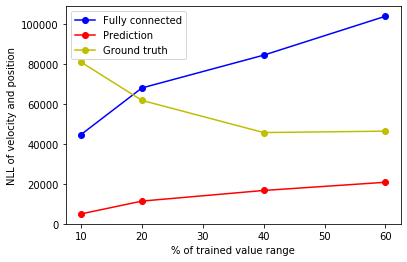

In [38]:
import matplotlib.pyplot as plt
# line 1 points
x=[10,20,40,60]
y1 = [ 44584.48323242,  67908.505     ,  84308.82375   ,103779.47890625]
y2 = [ 4891.17170898, 11307.67478516, 16619.263125  , 20724.26353516]
y3=[80817.77439453, 61684.21174805, 45588.25716797, 46295.07519531]
fig, ax = plt.subplots()
ax.plot(x, y1, 'bo-', label='Fully connected')
ax.plot(x, y2, 'ro-', label='Prediction')
ax.plot(x, y3, 'yo-', label='Ground truth')
ax.legend()
plt.xticks(np.arange(min(x), max(x)+1, 10))
plt.xlabel('% of trained value range')
plt.ylabel('NLL of velocity and position')
plt.savefig('inter_extra of different encoders')
plt.show()

In [10]:
p2='logs/exp2020-08-17T00:36:32.387949_train-bs_128_suffix_causal_vel_x0s_val-suffix_causal_vel_interpolation_input-atoms_6_dims_9_decoder-hidden_512_gt-A/best_decoder.pt'
extra_inter([p2])

loading valid_causal_vel_x0s_extrapolation_0_10%
batch_size 1
Nll tensor(4637.9170, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([1.0000e+01, 5.0000e+00, 5.0000e-03, 5.0000e-01, 1.7000e+00, 1.5000e+00],
       device='cuda:0')
Velocity 0 tensor([ 4.6554,  9.3107, 13.9661, 18.6215, 23.2768, 27.9322, 32.5876, 37.2430,
        41.8983, 46.5537, 51.2091, 55.8644, 60.5198, 65.1752, 69.8305, 74.4859,
        79.1413, 83.7966], device='cuda:0') 
 tensor([ 5.2576, 10.5146, 15.7775, 21.0421, 26.3117, 31.5882, 36.8689, 42.1629,
        47.4766, 52.8014, 58.1401, 63.4994, 68.8763, 74.2554, 79.6390, 85.0217,
        90.3975, 95.7529], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([  3.8277,  10.8107,  22.4491,  38.7429,  59.6921,  85.2966, 115.5565,
        150.4718, 190.0424, 234.2684, 283.1498, 336.6866, 394.8786, 457.7262,
        525.2290, 597.3872, 674.2008, 755.6698], device='cuda:0') 
 tensor([  17.2672,   37.4892,   62.8551,  

batch_size 1
Nll tensor(5891.7202, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([2.0000, 3.0000, 0.6100, 1.2600, 1.7000, 1.5000], device='cuda:0')
Velocity 7 tensor([  7.5023,  15.0046,  22.5069,  30.0092,  37.5116,  45.0139,  52.5162,
         60.0185,  67.5208,  75.0231,  82.5254,  90.0277,  97.5301, 105.0324,
        112.5347, 120.0370, 127.5393, 135.0416], device='cuda:0') 
 tensor([  8.2508,  16.5171,  24.7895,  33.0626,  41.3195,  49.5594,  57.7853,
         65.9987,  74.2272,  82.4957,  90.8017,  99.1566, 107.5447, 115.9524,
        124.3828, 132.8779, 141.4055, 149.7991], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 7 tensor([   5.2511,   16.5046,   35.2604,   61.5185,   95.2789,  136.5416,
         185.3067,  241.5740,  305.3436,  376.6156,  455.3899,  541.6665,
         635.4453,  736.7266,  845.5101,  961.7959, 1085.5841, 1216.8745],
       device='cuda:0') 
 tensor([  19.6537,   45.0566,   78.5155,  121.2913,  1

batch_size 1
Nll tensor(2138.3979, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 14 tensor([ 1.0000,  5.0000,  0.6000,  0.5000, 10.7000, 21.0000], device='cuda:0')
Velocity 14 tensor([-0.4618, -0.9236, -1.3854, -1.8473, -2.3091, -2.7709, -3.2327, -3.6945,
        -4.1563, -4.6182, -5.0800, -5.5418, -6.0036, -6.4654, -6.9272, -7.3890,
        -7.8509, -8.3127], device='cuda:0') 
 tensor([0.1077, 0.2211, 0.3403, 0.4653, 0.5961, 0.7327, 0.8752, 1.0234, 1.1775,
        1.3372, 1.5028, 1.6744, 1.8520, 2.0355, 2.2249, 2.4202, 2.6213, 2.8282],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 14 tensor([ 20.7691,  20.0764,  18.9218,  17.3055,  15.2273,  12.6873,   9.6855,
          6.2219,   2.2965,  -2.0908,  -6.9398, -12.2507, -18.0234, -24.2579,
        -30.9542, -38.1123, -45.7323, -53.8141], device='cuda:0') 
 tensor([ 25.7323,  30.6227,  35.6824,  40.9165,  46.3336,  51.9402,  57.7463,
         63.7672,  70.0120,  76.4864,  83.2021,  90.17

batch_size 1
Nll tensor(6146.0210, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 21 tensor([ 3.0000,  3.0000,  0.6100,  1.2600, 10.7000, 21.5000], device='cuda:0')
Velocity 21 tensor([  7.5023,  15.0046,  22.5069,  30.0092,  37.5116,  45.0139,  52.5162,
         60.0185,  67.5208,  75.0231,  82.5254,  90.0277,  97.5301, 105.0324,
        112.5347, 120.0370, 127.5393, 135.0416], device='cuda:0') 
 tensor([  8.2508,  16.5171,  24.7895,  33.0626,  41.3195,  49.5595,  57.7853,
         65.9988,  74.2272,  82.4957,  90.8017,  99.1566, 107.5447, 115.9523,
        124.3828, 132.8779, 141.4054, 149.7990], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 21 tensor([  25.2512,   36.5046,   55.2604,   81.5185,  115.2789,  156.5416,
         205.3066,  261.5740,  325.3436,  396.6156,  475.3899,  561.6665,
         655.4453,  756.7266,  865.5101,  981.7959, 1105.5840, 1236.8745],
       device='cuda:0') 
 tensor([  39.8954,   65.5379,   99.1538,  142

batch_size 1
Nll tensor(5896.8291, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 28 tensor([1.0000, 1.0000, 0.6100, 1.2600, 1.5000, 2.0000], device='cuda:0')
Velocity 28 tensor([  7.5023,  15.0046,  22.5069,  30.0092,  37.5116,  45.0139,  52.5162,
         60.0185,  67.5208,  75.0231,  82.5254,  90.0277,  97.5301, 105.0324,
        112.5347, 120.0370, 127.5393, 135.0416], device='cuda:0') 
 tensor([  8.2505,  16.5164,  24.7885,  33.0613,  41.3180,  49.5576,  57.7833,
         65.9965,  74.2248,  82.4931,  90.7989,  99.1536, 107.5416, 115.9492,
        124.3795, 132.8745, 141.4021, 149.7957], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 28 tensor([   5.7511,   17.0046,   35.7604,   62.0185,   95.7789,  137.0416,
         185.8066,  242.0740,  305.8437,  377.1156,  455.8899,  542.1665,
         635.9454,  737.2266,  846.0101,  962.2959, 1086.0841, 1217.3745],
       device='cuda:0') 
 tensor([  20.1569,   45.5634,   79.0259,  121.8047,

batch_size 1
Nll tensor(6168.8467, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 38 tensor([ 2.0000,  3.0000,  0.6000,  1.2600, 10.7000, 21.0000], device='cuda:0')
Velocity 38 tensor([  7.5323,  15.0646,  22.5968,  30.1291,  37.6614,  45.1937,  52.7260,
         60.2583,  67.7905,  75.3228,  82.8551,  90.3874,  97.9197, 105.4520,
        112.9842, 120.5165, 128.0488, 135.5811], device='cuda:0') 
 tensor([  8.2786,  16.5731,  24.8690,  33.1644,  41.4460,  49.7144,  57.9672,
         66.2153,  74.4738,  82.7723,  91.1045,  99.4890, 107.9107, 116.3529,
        124.8135, 133.3328, 141.8864, 150.2981], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 38 tensor([  24.7661,   36.0646,   54.8953,   81.2582,  115.1535,  156.5811,
         205.5409,  262.0331,  326.0574,  397.6141,  476.7030,  563.3243,
         657.4778,  759.1637,  868.3817,  985.1321, 1109.4148, 1241.2297],
       device='cuda:0') 
 tensor([  39.4694,   65.2178,   99.0034,  142

       grad_fn=<SelectBackward>)
Position 45 tensor([  25.6577,   39.6310,   62.9197,   95.5240,  137.4437,  188.6790,
         249.2297,  319.0960,  398.2777,  486.7750,  584.5878,  691.7161,
         808.1598,  933.9191, 1068.9938, 1213.3840, 1367.0897, 1530.1111],
       device='cuda:0') 
 tensor([  42.6430,   73.1279,  114.4824,  167.7368,  231.6308,  305.8263,
         390.0740,  483.5391,  585.7631,  698.0519,  820.2903,  952.2891,
        1094.6355, 1246.8049, 1406.8396, 1563.5732, 1696.6964, 1806.4404],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(5752.8789, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 46 tensor([ 2.0000,  7.0000,  0.6000,  1.3000,  1.7000, 21.0000], device='cuda:0')
Velocity 46 tensor([  7.8700,  15.7400,  23.6099,  31.4799,  39.3499,  47.2199,  55.0898,
         62.9598,  70.8298,  78.6998,  86.5697,  94.4397, 102.3097, 110.1797,
        118.0497, 125.9196, 133.7896, 141.6596], device='cuda:

batch_size 1
Nll tensor(9707.2568, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 4 tensor([1.0000, 5.0000, 0.6400, 1.3600, 0.5000, 1.0000], device='cuda:0')
Velocity 4 tensor([  8.2707,  16.5415,  24.8122,  33.0829,  41.3536,  49.6244,  57.8951,
         66.1658,  74.4366,  82.7073,  90.9780,  99.2487, 107.5195, 115.7902,
        124.0609, 132.3317, 140.6024, 148.8731], device='cuda:0') 
 tensor([  8.0369,  16.1064,  24.2126,  32.3387,  40.4734,  48.6241,  56.8023,
         64.9933,  73.2070,  81.4776,  89.7621,  98.0679, 106.4012, 114.7379,
        123.0199, 131.1710, 139.0381, 146.5078], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 4 tensor([   5.1354,   17.5415,   38.2183,   67.1659,  104.3841,  149.8731,
         203.6328,  265.6633,  335.9645,  414.5364,  501.3791,  596.4924,
         699.8766,  811.5314,  931.4569, 1059.6533, 1196.1204, 1340.8579],
       device='cuda:0') 
 tensor([  42.3862,   92.4712,  150.6104,  216.3462,  2

Setup [shapes,colors,mus,thetas,masses,v0s] 12 tensor([1.0000, 3.0000, 0.6500, 1.3600, 0.7000, 0.0000], device='cuda:0')
Velocity 12 tensor([  8.2502,  16.5004,  24.7507,  33.0009,  41.2511,  49.5013,  57.7516,
         66.0018,  74.2520,  82.5022,  90.7525,  99.0027, 107.2529, 115.5031,
        123.7533, 132.0036, 140.2538, 148.5040], device='cuda:0') 
 tensor([  8.0108,  16.0568,  24.1399,  32.2453,  40.3600,  48.4930,  56.6493,
         64.8175,  73.0023,  81.2410,  89.4989,  97.7838, 106.0995, 114.4237,
        122.6900, 130.8249, 138.6666, 146.1121], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 12 tensor([   4.1251,   16.5005,   37.1260,   66.0018,  103.1278,  148.5041,
         202.1305,  264.0071,  334.1341,  412.5111,  499.1385,  594.0160,
         697.1438,  808.5220,  928.1501, 1056.0286, 1192.1573, 1336.5361],
       device='cuda:0') 
 tensor([  41.2374,   91.1861,  149.1148,  214.5903,  286.5369,  364.6159,
         448.1534,  537.2869,  633.3259,  736.9546,  

batch_size 1
Nll tensor(9791.6631, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 20 tensor([ 2.0000,  1.0000,  0.6600,  1.3600,  0.7000, 22.0000], device='cuda:0')
Velocity 20 tensor([  8.2297,  16.4594,  24.6892,  32.9189,  41.1486,  49.3783,  57.6080,
         65.8377,  74.0675,  82.2972,  90.5269,  98.7566, 106.9863, 115.2160,
        123.4458, 131.6755, 139.9052, 148.1349], device='cuda:0') 
 tensor([  7.9865,  16.0109,  24.0715,  32.1565,  40.2508,  48.3662,  56.5010,
         64.6483,  72.8119,  81.0182,  89.2485,  97.5151, 105.8127, 114.1225,
        122.3734, 130.4912, 138.3119, 145.7324], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 20 tensor([  26.1149,   38.4594,   59.0337,   87.8377,  124.8715,  170.1349,
         223.6281,  285.3510,  355.3036,  433.4859,  519.8979,  614.5397,
         717.4111,  828.5123,  947.8433, 1075.4038, 1211.1941, 1355.2142],
       device='cuda:0') 
 tensor([  63.6225,  113.9124,  172.0045,  237

       device='cuda:0') 
 tensor([  64.9603,  116.8286,  176.9327,  245.1319,  319.9889,  400.8285,
         487.4923,  580.4819,  681.0145,  789.4221,  904.1071, 1023.5552,
        1143.5486, 1258.1344, 1361.4115, 1451.2375, 1527.7871, 1592.4873],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(9537.8262, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 29 tensor([ 3.0000,  7.0000,  0.6600,  1.3600, 10.9000,  1.0000], device='cuda:0')
Velocity 29 tensor([  8.2297,  16.4594,  24.6892,  32.9189,  41.1486,  49.3783,  57.6080,
         65.8377,  74.0675,  82.2972,  90.5269,  98.7566, 106.9863, 115.2160,
        123.4458, 131.6755, 139.9052, 148.1349], device='cuda:0') 
 tensor([  7.9866,  16.0110,  24.0716,  32.1567,  40.2510,  48.3665,  56.5013,
         64.6488,  72.8124,  81.0189,  89.2492,  97.5159, 105.8136, 114.1235,
        122.3746, 130.4924, 138.3132, 145.7337], device='cuda:0',
       grad_fn=<SelectBackward>)
Positio

Setup [shapes,colors,mus,thetas,masses,v0s] 39 tensor([ 3.0000,  5.0000,  0.6400,  1.4000, 11.5000,  0.0000], device='cuda:0')
Velocity 39 tensor([  8.5914,  17.1828,  25.7741,  34.3655,  42.9569,  51.5482,  60.1396,
         68.7310,  77.3224,  85.9137,  94.5051, 103.0965, 111.6879, 120.2792,
        128.8706, 137.4620, 146.0534, 154.6447], device='cuda:0') 
 tensor([  8.2058,  16.4448,  24.7196,  33.0274,  41.3588,  49.7173,  58.1079,
         66.5344,  75.0051,  83.5492,  92.1258, 100.7104, 109.3231, 117.9273,
        126.4530, 134.8372, 142.8705, 150.4585], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 39 tensor([   4.2957,   17.1828,   38.6612,   68.7310,  107.3922,  154.6447,
         210.4887,  274.9240,  347.9506,  429.5687,  519.7781,  618.5790,
         725.9711,  841.9546,  966.5295, 1099.6958, 1241.4535, 1391.8026],
       device='cuda:0') 
 tensor([  42.2549,   93.3556,  152.7428,  219.8968,  293.7122,  373.5701,
         458.8795,  550.0828,  648.5004,  754.6

batch_size 1
Nll tensor(13526.8252, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 46 tensor([10.0000,  7.0000,  0.6200,  0.3800,  0.7000,  1.0000], device='cuda:0')
Velocity 46 tensor([ -2.0075,  -4.0151,  -6.0226,  -8.0302, -10.0377, -12.0453, -14.0528,
        -16.0604, -18.0679, -20.0755, -22.0830, -24.0905, -26.0981, -28.1056,
        -30.1132, -32.1207, -34.1283, -36.1358], device='cuda:0') 
 tensor([0.0424, 0.0950, 0.1584, 0.2328, 0.3181, 0.4152, 0.5240, 0.6442, 0.7759,
        0.9192, 1.0750, 1.2434, 1.4240, 1.6165, 1.8209, 2.0360, 2.2610, 2.4954],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 46 tensor([-3.7537e-03, -3.0151e+00, -8.0339e+00, -1.5060e+01, -2.4094e+01,
        -3.5136e+01, -4.8185e+01, -6.3241e+01, -8.0306e+01, -9.9377e+01,
        -1.2046e+02, -1.4354e+02, -1.6864e+02, -1.9574e+02, -2.2485e+02,
        -2.5597e+02, -2.8909e+02, -3.2422e+02], device='cuda:0') 
 tensor([  7.9314,  15.1177,  22.5561,  30.2621,  38

batch_size 1
Nll tensor(20361.4375, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 4 tensor([10.0000,  7.0000,  0.7800,  0.3500, 13.0000, -2.0000], device='cuda:0')
Velocity 4 tensor([ -3.8202,  -7.6403, -11.4605, -15.2807, -19.1008, -22.9210, -26.7412,
        -30.5613, -34.3815, -38.2017, -42.0218, -45.8420, -49.6622, -53.4823,
        -57.3025, -61.1227, -64.9428, -68.7630], device='cuda:0') 
 tensor([0.1329, 0.2714, 0.4151, 0.5652, 0.7226, 0.8873, 1.0605, 1.2432, 1.4364,
        1.6408, 1.8567, 2.0839, 2.3226, 2.5734, 2.8356, 3.1086, 3.3936, 3.6899],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 4 tensor([  -3.9100,   -9.6403,  -19.1907,  -32.5613,  -49.7521,  -70.7629,
         -95.5941, -124.2454, -156.7167, -193.0083, -233.1201, -277.0520,
        -324.8040, -376.3763, -431.7687, -490.9813, -554.0140, -620.8669],
       device='cuda:0') 
 tensor([  2.3959,   6.9558,  11.6820,  16.5809,  21.6646,  26.9279,  32.3774,
         38.0

batch_size 1
Nll tensor(18035.6250, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 11 tensor([10.0000,  5.0000,  0.7000,  0.3500,  0.2000, 24.0000], device='cuda:0')
Velocity 11 tensor([ -3.0837,  -6.1674,  -9.2511, -12.3348, -15.4185, -18.5022, -21.5859,
        -24.6696, -27.7533, -30.8370, -33.9207, -37.0044, -40.0881, -43.1718,
        -46.2555, -49.3392, -52.4229, -55.5066], device='cuda:0') 
 tensor([ 0.4382,  0.8884,  1.3517,  1.8297,  2.3220,  2.8288,  3.3498,  3.8855,
         4.4364,  5.0024,  5.5830,  6.1775,  6.7862,  7.4091,  8.0455,  8.6955,
         9.3589, 10.0354], device='cuda:0', grad_fn=<SelectBackward>)
Position 11 tensor([  22.4583,   17.8327,   10.1234,   -0.6695,  -14.5461,  -31.5066,
         -51.5505,  -74.6783, -100.8898, -130.1848, -162.5637, -198.0263,
        -236.5724, -278.2025, -322.9160, -370.7134, -421.5944, -475.5591],
       device='cuda:0') 
 tensor([ 31.7769,  39.8063,  48.1183,  56.6916,  65.4938,  74.5562,  

batch_size 1
Nll tensor(18035.6387, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 18 tensor([ 3.0000,  7.0000,  0.7000,  0.3500,  0.2000, 24.0000], device='cuda:0')
Velocity 18 tensor([ -3.0837,  -6.1674,  -9.2511, -12.3348, -15.4185, -18.5022, -21.5859,
        -24.6696, -27.7533, -30.8370, -33.9207, -37.0044, -40.0881, -43.1718,
        -46.2555, -49.3392, -52.4229, -55.5066], device='cuda:0') 
 tensor([ 0.4382,  0.8884,  1.3517,  1.8297,  2.3220,  2.8288,  3.3498,  3.8855,
         4.4364,  5.0024,  5.5829,  6.1775,  6.7862,  7.4091,  8.0455,  8.6955,
         9.3589, 10.0354], device='cuda:0', grad_fn=<SelectBackward>)
Position 18 tensor([  22.4583,   17.8327,   10.1234,   -0.6695,  -14.5461,  -31.5066,
         -51.5505,  -74.6783, -100.8898, -130.1848, -162.5637, -198.0263,
        -236.5724, -278.2025, -322.9160, -370.7134, -421.5944, -475.5591],
       device='cuda:0') 
 tensor([ 31.7769,  39.8063,  48.1183,  56.6916,  65.4938,  74.5562,  

batch_size 1
Nll tensor(20419.6426, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 25 tensor([ 2.0000,  5.0000,  0.7800,  0.3500, 13.0000, 26.0000], device='cuda:0')
Velocity 25 tensor([ -3.8202,  -7.6403, -11.4605, -15.2807, -19.1008, -22.9210, -26.7412,
        -30.5613, -34.3815, -38.2017, -42.0218, -45.8420, -49.6622, -53.4823,
        -57.3025, -61.1227, -64.9428, -68.7630], device='cuda:0') 
 tensor([0.1329, 0.2714, 0.4151, 0.5652, 0.7226, 0.8873, 1.0605, 1.2432, 1.4364,
        1.6408, 1.8567, 2.0839, 2.3226, 2.5734, 2.8356, 3.1086, 3.3936, 3.6899],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 25 tensor([  24.0899,   18.3597,    8.8093,   -4.5613,  -21.7520,  -42.7629,
         -67.5941,  -96.2452, -128.7167, -165.0083, -205.1201, -249.0519,
        -296.8040, -348.3763, -403.7687, -462.9813, -526.0140, -592.8669],
       device='cuda:0') 
 tensor([ 30.4487,  35.0797,  39.9099,  44.9353,  50.1586,  55.5814,  61.2217,
         6

batch_size 1
Nll tensor(9248.9668, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 32 tensor([ 2.0000,  5.0000,  0.7800,  1.4500,  0.3000, -1.0000], device='cuda:0')
Velocity 32 tensor([  8.8075,  17.6149,  26.4224,  35.2299,  44.0373,  52.8448,  61.6523,
         70.4597,  79.2672,  88.0746,  96.8821, 105.6896, 114.4970, 123.3045,
        132.1120, 140.9194, 149.7269, 158.5344], device='cuda:0') 
 tensor([  8.6795,  17.3488,  26.0435,  34.7577,  43.4845,  52.1921,  60.8639,
         69.5160,  78.1843,  86.8452,  95.4650, 103.9756, 112.3573, 120.5127,
        128.4297, 136.0672, 143.3861, 150.3904], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 32 tensor([   3.4037,   16.6150,   38.6337,   69.4598,  109.0934,  157.5344,
         214.7829,  280.8389,  355.7023,  439.3732,  531.8516,  633.1375,
         743.2308,  862.1315,  989.8398, 1126.3555, 1271.6787, 1425.8093],
       device='cuda:0') 
 tensor([  75.4568,  155.2112,  237.5073,  322

batch_size 1
Nll tensor(9651.4941, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 39 tensor([ 1.0000,  1.0000,  0.7400,  1.4500,  0.3000, 26.0000], device='cuda:0')
Velocity 39 tensor([  8.8547,  17.7094,  26.5641,  35.4188,  44.2735,  53.1282,  61.9829,
         70.8376,  79.6923,  88.5470,  97.4017, 106.2564, 115.1111, 123.9658,
        132.8205, 141.6752, 150.5299, 159.3846], device='cuda:0') 
 tensor([  8.7816,  17.5577,  26.3414,  35.1547,  43.9737,  52.7719,  61.5286,
         70.2658,  79.0261,  87.7911,  96.5247, 105.1685, 113.6864, 121.9848,
        130.0631, 137.8571, 145.3076, 152.4475], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 39 tensor([  30.4274,   43.7095,   65.8462,   96.8376,  136.6838,  185.3846,
         242.9402,  309.3504,  384.6154,  468.7352,  561.7094,  663.5386,
         774.2224,  893.7608, 1022.1540, 1159.4019, 1305.5044, 1460.4617],
       device='cuda:0') 
 tensor([ 103.7167,  184.8127,  268.4776,  355

batch_size 1
Nll tensor(9337.0557, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 46 tensor([ 2.0000,  1.0000,  0.7800,  1.5000,  0.2000, -2.0000], device='cuda:0')
Velocity 46 tensor([  9.2347,  18.4695,  27.7042,  36.9389,  46.1737,  55.4084,  64.6432,
         73.8779,  83.1126,  92.3474, 101.5821, 110.8168, 120.0516, 129.2863,
        138.5210, 147.7558, 156.9905, 166.2253], device='cuda:0') 
 tensor([  8.9352,  17.8619,  26.8132,  35.7785,  44.7596,  53.7180,  62.6708,
         71.6184,  80.5627,  89.5037,  98.3959, 107.1929, 115.8332, 124.2275,
        132.3857, 140.2388, 147.7483, 154.8966], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 46 tensor([   2.6174,   16.4695,   39.5563,   71.8779,  113.4343,  164.2253,
         224.2510,  293.5115,  372.0069,  459.7369,  556.7016,  662.9011,
         778.3351,  903.0042, 1036.9077, 1180.0461, 1332.4194, 1494.0273],
       device='cuda:0') 
 tensor([  76.2441,  158.0115,  242.5186,  329

batch_size 1
Nll tensor(7100.0088, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 4 tensor([ 3.0000,  7.0000,  0.8900,  1.5300, 14.6000, -5.0000], device='cuda:0')
Velocity 4 tensor([  9.4361,  18.8722,  28.3083,  37.7445,  47.1806,  56.6167,  66.0528,
         75.4890,  84.9251,  94.3612, 103.7973, 113.2334, 122.6695, 132.1057,
        141.5418, 150.9779, 160.4140, 169.8501], device='cuda:0') 
 tensor([  9.6959,  19.3205,  28.8612,  38.3109,  47.6402,  56.8397,  65.8950,
         74.8067,  83.6009,  92.2532, 100.7320, 109.0045, 117.0785, 124.9445,
        132.5836, 139.9347, 147.0032, 153.8017], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 4 tensor([-2.8198e-01,  1.3872e+01,  3.7463e+01,  7.0489e+01,  1.1295e+02,
         1.6485e+02,  2.2618e+02,  2.9696e+02,  3.7716e+02,  4.6681e+02,
         5.6589e+02,  6.7440e+02,  7.9235e+02,  9.1974e+02,  1.0566e+03,
         1.2028e+03,  1.3585e+03,  1.5237e+03], device='cuda:0') 
 tensor([  8

        142.0814, 151.5535, 161.0255, 170.4976], device='cuda:0') 
 tensor([  9.9244,  19.7949,  29.6151,  39.3369,  48.9591,  58.4574,  67.8554,
         77.1313,  86.3088,  95.3370, 104.1868, 112.7760, 121.1318, 129.2501,
        137.1105, 144.7210, 152.0682, 159.1566], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 12 tensor([  -2.2639,   11.9441,   35.6243,   68.7766,  111.4011,  163.4976,
         225.0662,  296.1068,  376.6196,  466.6046,  566.0614,  674.9906,
         793.3916,  921.2648, 1058.6102, 1205.4276, 1361.7169, 1527.4789],
       device='cuda:0') 
 tensor([  84.1321,  175.7698,  267.5564,  358.9525,  450.9110,  542.7747,
         633.2744,  722.1067,  808.8844,  892.7802,  973.5878, 1050.3593,
        1122.3348, 1189.6058, 1252.3798, 1310.9103, 1365.7028, 1416.7982],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(7527.0269, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 13 tensor([10.0000,  7.

batch_size 1
Nll tensor(31372.7227, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 22 tensor([ 2.0000,  5.0000,  0.8700,  0.2100, 13.5000, -5.0000], device='cuda:0')
Velocity 22 tensor([  -6.2958,  -12.5916,  -18.8874,  -25.1831,  -31.4789,  -37.7747,
         -44.0705,  -50.3663,  -56.6621,  -62.9578,  -69.2536,  -75.5494,
         -81.8452,  -88.1410,  -94.4368, -100.7326, -107.0283, -113.3241],
       device='cuda:0') 
 tensor([0.2945, 0.5958, 0.9046, 1.2202, 1.5416, 1.8696, 2.2046, 2.5478, 2.8991,
        3.2586, 3.6282, 4.0021, 4.3789, 4.7576, 5.1393, 5.5253, 5.9159, 6.3113],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 22 tensor([   -8.1479,   -17.5917,   -33.3311,   -55.3663,   -83.6973,  -118.3242,
         -159.2468,  -206.4652,  -259.9793,  -319.7892,  -385.8950,  -458.2964,
         -536.9938,  -621.9869,  -713.2758,  -810.8605,  -914.7408, -1024.9171],
       device='cuda:0') 
 tensor([-4.6627, -4.2360, -3.7131, -3.1088, -

batch_size 1
Nll tensor(7692.0522, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 29 tensor([ 3.0000,  1.0000,  0.8000,  1.5700, 14.6000, 27.0000], device='cuda:0')
Velocity 29 tensor([  9.7937,  19.5875,  29.3812,  39.1750,  48.9688,  58.7625,  68.5563,
         78.3500,  88.1438,  97.9375, 107.7313, 117.5250, 127.3188, 137.1126,
        146.9063, 156.7000, 166.4938, 176.2876], device='cuda:0') 
 tensor([ 10.1725,  20.2808,  30.3345,  40.2895,  50.1176,  59.8335,  69.4476,
         78.9511,  88.3634,  97.6169, 106.6856, 115.5094, 124.0342, 132.3189,
        140.3370, 148.0935, 155.5716, 162.7885], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 29 tensor([  31.8969,   46.5874,   71.0719,  105.3500,  149.4219,  203.2875,
         266.9469,  340.4000,  423.6470,  516.6876,  619.5220,  732.1503,
         854.5721,  986.7877, 1128.7972, 1280.6002, 1442.1974, 1613.5880],
       device='cuda:0') 
 tensor([ 120.3197,  213.8600,  307.4431,  401

batch_size 1
Nll tensor(7318.3188, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 36 tensor([10.0000,  1.0000,  0.8400,  1.5300, 13.2000, -7.0000], device='cuda:0')
Velocity 36 tensor([  9.4561,  18.9122,  28.3683,  37.8244,  47.2805,  56.7366,  66.1927,
         75.6488,  85.1049,  94.5610, 104.0171, 113.4732, 122.9293, 132.3854,
        141.8415, 151.2977, 160.7538, 170.2099], device='cuda:0') 
 tensor([  9.8090,  19.5550,  29.2250,  38.7964,  48.2601,  57.6022,  66.8337,
         75.9385,  84.9478,  93.8306, 102.5330, 111.0155, 119.2569, 127.2756,
        135.0494, 142.5600, 149.7767, 156.7473], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 36 tensor([  -2.2720,   11.9121,   35.5524,   68.6488,  111.2013,  163.2098,
         224.6744,  295.5953,  375.9722,  465.8052,  565.0941,  673.8395,
         792.0406,  919.6981, 1056.8116, 1203.3812, 1359.4069, 1524.8888],
       device='cuda:0') 
 tensor([  83.3801,  174.1440,  264.6962,  354

 tensor([0.2522, 0.5099, 0.7727, 1.0404, 1.3135, 1.5916, 1.8755, 2.1656, 2.4623,
        2.7658, 3.0757, 3.3921, 3.7176, 4.0527, 4.3980, 4.7540, 5.1212, 5.4997],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 43 tensor([   23.5887,    13.3551,    -3.7012,   -27.5797,   -58.2809,   -95.8043,
         -140.1505,  -191.3190,  -249.3099,  -314.1232,  -385.7592,  -464.2175,
         -549.4984,  -641.6016,  -740.5273,  -846.2755,  -958.8462, -1078.2394],
       device='cuda:0') 
 tensor([26.5154, 26.1154, 25.8104, 25.6222, 25.5372, 25.5551, 25.6747, 25.9257,
        26.3187, 26.8556, 27.5321, 28.3417, 29.2659, 30.2827, 31.4072, 32.6565,
        34.0359, 35.5582], device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(32577.7344, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 44 tensor([10.0000,  1.0000,  0.8900,  0.2100, 13.5000, 29.0000], device='cuda:0')
Velocity 44 tensor([  -6.4875,  -12.9750,  -19.4624,  -25.9499,  -32.4374, 

batch_size 1
Nll tensor(26.0663, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 4 tensor([ 7.0000,  2.0000,  0.4800,  1.1636,  2.3000, 14.0000], device='cuda:0')
Velocity 4 tensor([  7.1354,  14.2707,  21.4061,  28.5414,  35.6768,  42.8122,  49.9475,
         57.0829,  64.2182,  71.3536,  78.4889,  85.6243,  92.7597,  99.8950,
        107.0304, 114.1657, 121.3011, 128.4365], device='cuda:0') 
 tensor([  7.0468,  14.1093,  21.1782,  28.2535,  35.3129,  42.3727,  49.4173,
         56.4344,  63.4345,  70.4201,  77.4122,  84.4260,  91.4447,  98.4579,
        105.4560, 112.4399, 119.4207, 126.3704], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 4 tensor([  17.5677,   28.2707,   46.1091,   71.0829,  103.1920,  142.4364,
         188.8163,  242.3315,  302.9821,  370.7679,  445.6892,  527.7458,
         616.9378,  713.2651,  816.7279,  927.3259, 1045.0593, 1169.9281],
       device='cuda:0') 
 tensor([  20.0288,   31.3801,   49.6057,   74.2585

        368.9112, 417.8100, 469.8637, 525.0721], device='cuda:0') 
 tensor([ 17.0482,  22.1681,  30.0390,  41.1010,  55.4418,  73.1011,  93.9828,
        117.9620, 145.1502, 175.4945, 208.8821, 245.3844, 284.9817, 327.6637,
        373.3682, 422.1210, 473.4357, 527.0931], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(351.3213, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 12 tensor([5.0000, 2.0000, 0.2600, 1.1636, 3.6000, 8.0000], device='cuda:0')
Velocity 12 tensor([  7.9893,  15.9786,  23.9679,  31.9572,  39.9465,  47.9358,  55.9251,
         63.9145,  71.9038,  79.8931,  87.8824,  95.8717, 103.8610, 111.8503,
        119.8396, 127.8289, 135.8182, 143.8075], device='cuda:0') 
 tensor([  7.7019,  15.3854,  23.0610,  30.7444,  38.4227,  46.0739,  53.7044,
         61.3339,  68.9452,  76.5553,  84.1621,  91.7593,  99.3410, 106.8953,
        114.4353, 122.0010, 129.5525, 137.0300], device='cuda:0',
       grad_fn=<SelectB

batch_size 1
Nll tensor(18.9444, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 19 tensor([7.0000, 8.0000, 0.5000, 0.8491, 3.6000, 5.9000], device='cuda:0')
Velocity 19 tensor([ 4.1193,  8.2386, 12.3578, 16.4771, 20.5964, 24.7157, 28.8350, 32.9543,
        37.0735, 41.1928, 45.3121, 49.4314, 53.5507, 57.6700, 61.7892, 65.9085,
        70.0278, 74.1471], device='cuda:0') 
 tensor([ 4.1696,  8.3608, 12.5626, 16.7748, 20.9901, 25.2017, 29.4066, 33.6023,
        37.7895, 41.9675, 46.1408, 50.3149, 54.4827, 58.6457, 62.8144, 66.9954,
        71.1940, 75.4216], device='cuda:0', grad_fn=<SelectBackward>)
Position 19 tensor([  7.9597,  14.1385,  24.4368,  38.8543,  57.3910,  80.0471, 106.8224,
        137.7171, 172.7309, 211.8641, 255.1166, 302.4883, 353.9794, 409.5897,
        469.3193, 533.1682, 601.1363, 673.2238], device='cuda:0') 
 tensor([  9.5997,  16.2946,  26.7382,  41.2357,  59.9459,  83.0773, 110.4995,
        142.2545, 178.3039, 218.5155, 262.2

batch_size 1
Nll tensor(14.2961, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 27 tensor([ 7.0000,  8.0000,  0.5000,  1.1636,  3.6000, 12.0000], device='cuda:0')
Velocity 27 tensor([  7.0577,  14.1155,  21.1732,  28.2309,  35.2886,  42.3464,  49.4041,
         56.4618,  63.5195,  70.5773,  77.6350,  84.6927,  91.7505,  98.8082,
        105.8659, 112.9236, 119.9814, 127.0391], device='cuda:0') 
 tensor([  6.9889,  14.0039,  21.0306,  28.0599,  35.0757,  42.0843,  49.0807,
         56.0532,  63.0063,  69.9479,  76.8997,  83.8677,  90.8336,  97.7875,
        104.7261, 111.6478, 118.5725, 125.4819], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 27 tensor([  15.5288,   26.1154,   43.7598,   68.4618,  100.2216,  139.0391,
         184.9143,  237.8473,  297.8380,  364.8864,  438.9925,  520.1564,
         608.3779,  703.6572,  805.9943,  915.3890, 1031.8416, 1155.3518],
       device='cuda:0') 
 tensor([  18.0280,   29.3310,   47.4473,   71.9

batch_size 1
Nll tensor(22.1067, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 35 tensor([ 8.0000,  8.0000,  0.5000,  0.8491,  2.3000, 14.0000], device='cuda:0')
Velocity 35 tensor([ 4.1193,  8.2386, 12.3578, 16.4771, 20.5964, 24.7157, 28.8350, 32.9543,
        37.0735, 41.1928, 45.3121, 49.4314, 53.5507, 57.6700, 61.7892, 65.9085,
        70.0278, 74.1471], device='cuda:0') 
 tensor([ 4.1696,  8.3608, 12.5626, 16.7748, 20.9901, 25.2017, 29.4066, 33.6023,
        37.7895, 41.9675, 46.1408, 50.3149, 54.4827, 58.6457, 62.8144, 66.9954,
        71.1940, 75.4216], device='cuda:0', grad_fn=<SelectBackward>)
Position 35 tensor([ 16.0597,  22.2386,  32.5368,  46.9543,  65.4911,  88.1471, 114.9224,
        145.8170, 180.8309, 219.9641, 263.2166, 310.5883, 362.0794, 417.6897,
        477.4193, 541.2682, 609.2363, 681.3238], device='cuda:0') 
 tensor([ 17.6738,  24.3846,  34.8666,  49.4134,  68.1958,  91.4167, 118.9187,
        150.7691, 186.9129, 227.2400,

batch_size 1
Nll tensor(18.8413, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 45 tensor([7.0000, 4.0000, 0.5000, 0.8491, 3.6000, 5.9000], device='cuda:0')
Velocity 45 tensor([ 4.1193,  8.2386, 12.3578, 16.4771, 20.5964, 24.7157, 28.8350, 32.9543,
        37.0735, 41.1928, 45.3121, 49.4314, 53.5507, 57.6700, 61.7892, 65.9085,
        70.0278, 74.1471], device='cuda:0') 
 tensor([ 4.1696,  8.3608, 12.5625, 16.7746, 20.9898, 25.2012, 29.4058, 33.6013,
        37.7881, 41.9657, 46.1386, 50.3123, 54.4796, 58.6421, 62.8103, 66.9907,
        71.1888, 75.4159], device='cuda:0', grad_fn=<SelectBackward>)
Position 45 tensor([  7.9597,  14.1385,  24.4368,  38.8543,  57.3910,  80.0471, 106.8224,
        137.7171, 172.7309, 211.8641, 255.1166, 302.4883, 353.9794, 409.5897,
        469.3193, 533.1682, 601.1363, 673.2238], device='cuda:0') 
 tensor([  9.5997,  16.2946,  26.7381,  41.2355,  59.9455,  83.0765, 110.4980,
        142.2521, 178.3003, 218.5103, 262.2

(array([[ 4891.17170898, 11307.67478516, 16619.263125  , 20724.26353516]]),
 [118.81984316825867])

In [5]:
p3='logs/exp2020-08-19T13:25:27.252372_train-bs_144_suffix_grouped_46656_x0s_manual_val-suffix_interpolation_decoder-hidden_512_val-grouped/best_decoder.pt'
extra_inter([p3])

loading valid_causal_vel_x0s_extrapolation_0_10%
loading rel_graph
batch_size 1
Nll tensor(103674.0156, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 2.0000,  3.0000,  0.6000,  1.2600, 10.3000,  1.5000], device='cuda:0')
Velocity 0 tensor([  7.5323,  15.0646,  22.5968,  30.1291,  37.6614,  45.1937,  52.7260,
         60.2583,  67.7905,  75.3228,  82.8551,  90.3874,  97.9197, 105.4520,
        112.9842, 120.5165, 128.0488, 135.5811], device='cuda:0') 
 tensor([0.3221, 0.6380, 0.9485, 1.2539, 1.5541, 1.8497, 2.1412, 2.4283, 2.7108,
        2.9888, 3.2614, 3.5291, 3.7908, 4.0463, 4.2961, 4.5410, 4.7814, 5.0171],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([   5.2661,   16.5646,   35.3953,   61.7583,   95.6535,  137.0811,
         186.0409,  242.5330,  306.5574,  378.1141,  457.2031,  543.8243,
         637.9779,  739.6637,  848.8818,  965.6321, 1089.9148, 1221.7296],
       device='cuda:0') 
 tensor([ 1.9533,  2.379

batch_size 1
Nll tensor(153882.8906, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 10 tensor([10.0000,  5.0000,  0.0000,  1.3000,  1.5000, 21.5000], device='cuda:0')
Velocity 10 tensor([  9.4429,  18.8857,  28.3286,  37.7715,  47.2144,  56.6572,  66.1001,
         75.5430,  84.9858,  94.4287, 103.8716, 113.3144, 122.7573, 132.2002,
        141.6431, 151.0859, 160.5288, 169.9717], device='cuda:0') 
 tensor([ 0.8274,  1.5939,  2.3063,  2.9723,  3.5990,  4.1942,  4.7657,  5.3152,
         5.8429,  6.3522,  6.8444,  7.3183,  7.7779,  8.2293,  8.6710,  9.2539,
         9.9915, 10.9416], device='cuda:0', grad_fn=<SelectBackward>)
Position 10 tensor([  26.2214,   40.3857,   63.9929,   97.0430,  139.5359,  191.4717,
         252.8503,  323.6719,  403.9362,  493.6435,  592.7937,  701.3867,
         819.4226,  946.9012, 1083.8229, 1230.1874, 1385.9948, 1551.2450],
       device='cuda:0') 
 tensor([ 22.9214,  24.3248,  25.7258,  27.1150,  28.4636,  29.7597, 

batch_size 1
Nll tensor(159449.5625, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 19 tensor([ 1.0000,  7.0000,  0.0000,  1.2600,  1.7000, 21.5000], device='cuda:0')
Velocity 19 tensor([  9.3305,  18.6610,  27.9915,  37.3219,  46.6524,  55.9829,  65.3134,
         74.6439,  83.9744,  93.3049, 102.6353, 111.9658, 121.2963, 130.6268,
        139.9573, 149.2878, 158.6183, 167.9487], device='cuda:0') 
 tensor([0.4194, 0.8260, 1.2216, 1.6071, 1.9812, 2.3437, 2.6959, 3.0381, 3.3716,
        3.6966, 4.0130, 4.3213, 4.6222, 4.9167, 5.2060, 5.4916, 5.7737, 6.0518],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 19 tensor([  26.1652,   40.1609,   63.4872,   96.1439,  138.1311,  189.4488,
         250.0969,  320.0755,  399.3847,  488.0243,  585.9944,  693.2949,
         809.9260,  935.8876, 1071.1796, 1215.8021, 1369.7551, 1533.0387],
       device='cuda:0') 
 tensor([21.8274, 22.1716, 22.5332, 22.9126, 23.3104, 23.7303, 24.1732, 24.6403,
       

batch_size 1
Nll tensor(106878.6953, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 27 tensor([3.0000, 3.0000, 0.6100, 1.3000, 1.5000, 1.5000], device='cuda:0')
Velocity 27 tensor([  7.8438,  15.6875,  23.5313,  31.3750,  39.2188,  47.0626,  54.9063,
         62.7501,  70.5939,  78.4376,  86.2814,  94.1251, 101.9689, 109.8127,
        117.6564, 125.5002, 133.3440, 141.1877], device='cuda:0') 
 tensor([0.7522, 1.4540, 2.1170, 2.7458, 3.3407, 3.9073, 4.4511, 4.9730, 5.4763,
        5.9621, 6.4307, 6.8835, 7.3210, 7.7434, 8.1526, 8.5518, 8.9400, 9.3184],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 27 tensor([   5.4219,   17.1875,   36.7969,   64.2501,   99.5470,  142.6877,
         193.6722,  252.5004,  319.1724,  393.6881,  476.0476,  566.2510,
         664.2980,  770.1887,  883.9232, 1005.5015, 1134.9237, 1272.1895],
       device='cuda:0') 
 tensor([ 2.4379,  3.4010,  4.3941,  5.4225,  6.4902,  7.6004,  8.7531,  9.9508,
        11.19

batch_size 1
Nll tensor(1959.1158, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 36 tensor([ 1.0000,  1.0000,  0.6000,  0.4600, 10.7000,  1.5000], device='cuda:0')
Velocity 36 tensor([ -0.9181,  -1.8362,  -2.7543,  -3.6724,  -4.5905,  -5.5086,  -6.4267,
         -7.3448,  -8.2629,  -9.1810, -10.0991, -11.0172, -11.9353, -12.8534,
        -13.7715, -14.6896, -15.6077, -16.5257], device='cuda:0') 
 tensor([0.0969, 0.1884, 0.2738, 0.3531, 0.4261, 0.4916, 0.5504, 0.6032, 0.6509,
        0.6939, 0.7325, 0.7670, 0.7976, 0.8244, 0.8479, 0.8686, 0.8869, 0.9026],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 36 tensor([   1.0409,   -0.3362,   -2.6315,   -5.8448,   -9.9762,  -15.0258,
         -20.9934,  -27.8791,  -35.6829,  -44.4049,  -54.0449,  -64.6030,
         -76.0792,  -88.4735, -101.7859, -116.0164, -131.1650, -147.2317],
       device='cuda:0') 
 tensor([ 1.3335,  1.1669,  0.9977,  0.8212,  0.6399,  0.4552,  0.2655,  0.0789,
        -

 tensor([0.4326, 0.8584, 1.2778, 1.6911, 2.0994, 2.5032, 2.9027, 3.2981, 3.6895,
        4.0773, 4.4628, 4.8446, 5.2222, 5.5953, 5.9645, 6.3313, 6.6962, 7.0587],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 44 tensor([ 23.1753,  29.7014,  40.5781,  55.8055,  75.3837,  99.3124, 127.5919,
        160.2221, 197.2030, 238.5345, 284.2168, 334.2498, 388.6335, 447.3678,
        510.4528, 577.8885, 649.6749, 725.8120], device='cuda:0') 
 tensor([22.0771, 23.1380, 24.1656, 25.1376, 26.0541, 26.9224, 27.7503, 28.5348,
        29.2753, 30.0158, 30.7617, 31.5148, 32.2828, 33.1043, 34.0113, 35.0613,
        36.2718, 37.5619], device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(31600.7031, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 45 tensor([ 1.0000,  3.0000,  0.0000,  0.4600, 10.3000, 21.5000], device='cuda:0')
Velocity 45 tensor([ 4.3507,  8.7014, 13.0521, 17.4028, 21.7535, 26.1042, 30.4548, 34.8055,
        39.1562, 43.5069, 

batch_size 1
Nll tensor(108003.6484, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 3 tensor([2.0000, 5.0000, 0.6600, 1.3600, 0.7000, 0.0000], device='cuda:0')
Velocity 3 tensor([  8.2297,  16.4594,  24.6892,  32.9189,  41.1486,  49.3783,  57.6080,
         65.8377,  74.0675,  82.2972,  90.5269,  98.7566, 106.9863, 115.2160,
        123.4458, 131.6755, 139.9052, 148.1349], device='cuda:0') 
 tensor([0.3499, 0.6979, 1.0427, 1.3842, 1.7231, 2.0590, 2.3921, 2.7227, 3.0514,
        3.3778, 3.7028, 4.0272, 4.3505, 4.6731, 4.9951, 5.3173, 5.6400, 5.9634],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 3 tensor([   4.1148,   16.4594,   37.0338,   65.8377,  102.8715,  148.1349,
         201.6281,  263.3510,  333.3036,  411.4859,  497.8979,  592.5397,
         695.4113,  806.5123,  925.8433, 1053.4039, 1189.1943, 1333.2144],
       device='cuda:0') 
 tensor([ 2.8466,  5.7238,  8.6227, 11.5608, 14.5320, 17.5318, 20.5778, 23.6380,
        26.7230,

batch_size 1
Nll tensor(10542.5742, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 14 tensor([ 1.0000,  7.0000,  0.6600,  0.4000, 11.5000,  0.0000], device='cuda:0')
Velocity 14 tensor([ -2.1411,  -4.2822,  -6.4234,  -8.5645, -10.7056, -12.8467, -14.9879,
        -17.1290, -19.2701, -21.4112, -23.5523, -25.6935, -27.8346, -29.9757,
        -32.1168, -34.2580, -36.3991, -38.5402], device='cuda:0') 
 tensor([0.2980, 0.5934, 0.8862, 1.1765, 1.4642, 1.7495, 2.0327, 2.3139, 2.5931,
        2.8710, 3.1473, 3.4221, 3.6954, 3.9674, 4.2382, 4.5079, 4.7767, 5.0446],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 14 tensor([  -1.0705,   -4.2823,   -9.6350,  -17.1290,  -26.7640,  -38.5402,
         -52.4575,  -68.5159,  -86.7155, -107.0562, -129.5379, -154.1608,
        -180.9249, -209.8300, -240.8763, -274.0637, -309.3922, -346.8619],
       device='cuda:0') 
 tensor([ 1.5935,  3.1911,  4.7927,  6.3973,  8.0031,  9.6031, 11.1988, 12.7935,
        

Position 21 tensor([  27.1559,   39.6235,   60.4028,   89.4939,  126.8968,  172.6113,
         226.6376,  288.9757,  359.6254,  438.5869,  525.8602,  621.4453,
         725.3419,  837.5504,  958.0707, 1086.9027, 1224.0463, 1369.5018],
       device='cuda:0') 
 tensor([26.7819, 30.5828, 34.3945, 38.2151, 42.0416, 45.8640, 49.6905, 53.5229,
        57.3575, 61.1959, 65.0430, 68.8935, 72.7470, 76.6032, 80.4624, 84.3214,
        88.1787, 92.0353], device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(13182.7363, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 22 tensor([ 3.0000,  5.0000,  0.6500,  0.3800, 10.9000,  1.0000], device='cuda:0')
Velocity 22 tensor([ -2.2806,  -4.5611,  -6.8417,  -9.1223, -11.4029, -13.6834, -15.9640,
        -18.2446, -20.5252, -22.8057, -25.0863, -27.3669, -29.6474, -31.9280,
        -34.2086, -36.4892, -38.7697, -41.0503], device='cuda:0') 
 tensor([0.3837, 0.7674, 1.1509, 1.5336, 1.9152, 2.2953, 2.6736, 3.049

batch_size 1
Nll tensor(118641.5312, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 32 tensor([ 1.0000,  1.0000,  0.6600,  1.4000, 10.9000,  0.0000], device='cuda:0')
Velocity 32 tensor([  8.5581,  17.1161,  25.6742,  34.2322,  42.7903,  51.3484,  59.9064,
         68.4645,  77.0225,  85.5806,  94.1387, 102.6967, 111.2548, 119.8128,
        128.3709, 136.9290, 145.4870, 154.0451], device='cuda:0') 
 tensor([0.3489, 0.6991, 1.0515, 1.4060, 1.7624, 2.1210, 2.4823, 2.8461, 3.2125,
        3.5799, 3.9479, 4.3156, 4.6821, 5.0479, 5.4135, 5.7785, 6.1417, 6.5035],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 32 tensor([   4.2790,   17.1161,   38.5113,   68.4645,  106.9757,  154.0451,
         209.6725,  273.8579,  346.6015,  427.9030,  517.7626,  616.1803,
         723.1561,  838.6899,  962.7817, 1095.4316, 1236.6396, 1386.4058],
       device='cuda:0') 
 tensor([ 1.6271,  3.2720,  4.9413,  6.6346,  8.3446, 10.0699, 11.8081, 13.5613,
       

batch_size 1
Nll tensor(9292.7090, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 42 tensor([10.0000,  7.0000,  0.6200,  0.3800,  0.7000,  1.0000], device='cuda:0')
Velocity 42 tensor([ -2.0075,  -4.0151,  -6.0226,  -8.0302, -10.0377, -12.0453, -14.0528,
        -16.0604, -18.0679, -20.0755, -22.0830, -24.0905, -26.0981, -28.1056,
        -30.1132, -32.1207, -34.1283, -36.1358], device='cuda:0') 
 tensor([0.3090, 0.6177, 0.9261, 1.2344, 1.5434, 1.8531, 2.1635, 2.4745, 2.7862,
        3.0989, 3.4125, 3.7270, 4.0424, 4.3587, 4.6759, 4.9939, 5.3127, 5.6323],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 42 tensor([-3.7537e-03, -3.0151e+00, -8.0339e+00, -1.5060e+01, -2.4094e+01,
        -3.5136e+01, -4.8185e+01, -6.3241e+01, -8.0306e+01, -9.9377e+01,
        -1.2046e+02, -1.4354e+02, -1.6864e+02, -1.9574e+02, -2.2485e+02,
        -2.5597e+02, -2.8909e+02, -3.2422e+02], device='cuda:0') 
 tensor([ 2.1644,  3.3406,  4.5215,  5.7043,  6.8875,

loading rel_graph
batch_size 1
Nll tensor(70517.3281, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([10.0000,  3.0000,  0.7400,  1.5000, 12.0000, 24.0000], device='cuda:0')
Velocity 0 tensor([  9.2625,  18.5249,  27.7874,  37.0499,  46.3123,  55.5748,  64.8373,
         74.0997,  83.3622,  92.6246, 101.8871, 111.1496, 120.4120, 129.6745,
        138.9370, 148.1994, 157.4619, 166.7244], device='cuda:0') 
 tensor([ 1.0273,  2.0410,  3.0472,  4.0451,  5.0357,  6.0172,  6.9862,  7.9445,
         8.8969,  9.8448, 10.7900, 11.7330, 12.6724, 13.6057, 14.5329, 15.4538,
        16.3689, 17.2782], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([  28.6313,   42.5250,   65.6812,   98.0998,  139.7809,  190.7244,
         250.9305,  320.3989,  399.1299,  487.1234,  584.3792,  690.8975,
         806.6783,  931.7216, 1066.0273, 1209.5955, 1362.4263, 1524.5195],
       device='cuda:0') 
 tensor([ 31.6990,  39.3734,  47.0270,  54.6548,  62.25

Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([ 2.0000,  7.0000,  0.7800,  1.5000,  0.3000, 26.0000], device='cuda:0')
Velocity 7 tensor([  9.2347,  18.4695,  27.7042,  36.9389,  46.1737,  55.4084,  64.6432,
         73.8779,  83.1126,  92.3474, 101.5821, 110.8168, 120.0516, 129.2863,
        138.5210, 147.7558, 156.9905, 166.2253], device='cuda:0') 
 tensor([ 0.8429,  1.6818,  2.5138,  3.3390,  4.1584,  4.9729,  5.7825,  6.5859,
         7.3838,  8.1763,  8.9637,  9.7469, 10.5276, 11.3069, 12.0851, 12.8622,
        13.6367, 14.4094], device='cuda:0', grad_fn=<SelectBackward>)
Position 7 tensor([  30.6174,   44.4695,   67.5564,   99.8779,  141.4343,  192.2252,
         252.2510,  321.5115,  400.0068,  487.7369,  584.7016,  690.9011,
         806.3353,  931.0041, 1064.9077, 1208.0464, 1360.4194, 1522.0273],
       device='cuda:0') 
 tensor([30.0671, 34.1021, 38.1164, 42.1262, 46.1323, 50.1556, 54.1968, 58.2503,
        62.3049, 66.3558, 70.4036, 74.4514, 78.5045, 82.5699, 86.6469

batch_size 1
Nll tensor(34317.0547, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([ 3.0000,  1.0000,  0.7800,  0.2400, 12.0000, 24.0000], device='cuda:0')
Velocity 15 tensor([ -5.0954, -10.1908, -15.2863, -20.3817, -25.4771, -30.5725, -35.6680,
        -40.7634, -45.8588, -50.9542, -56.0496, -61.1451, -66.2405, -71.3359,
        -76.4313, -81.5267, -86.6222, -91.7176], device='cuda:0') 
 tensor([ 0.6558,  1.3162,  1.9857,  2.6585,  3.3343,  4.0111,  4.6928,  5.3894,
         6.1007,  6.8269,  7.5656,  8.3182,  9.0844,  9.8636, 10.6554, 11.4639,
        12.2866, 13.1197], device='cuda:0', grad_fn=<SelectBackward>)
Position 15 tensor([  21.4523,   13.8092,    1.0707,  -16.7633,  -39.6928,  -67.7176,
        -100.8378, -139.0535, -182.3646, -230.7711, -284.2730, -342.8703,
        -406.5631, -475.3513, -549.2349, -628.2140, -712.2884, -801.4583],
       device='cuda:0') 
 tensor([27.7728, 31.4347, 35.0478, 38.6230, 42.1435, 45.5965, 48.9725

Setup [shapes,colors,mus,thetas,masses,v0s] 22 tensor([ 3.0000,  7.0000,  0.7000,  1.4500,  0.3000, 24.0000], device='cuda:0')
Velocity 22 tensor([  8.9019,  17.8039,  26.7058,  35.6077,  44.5097,  53.4116,  62.3136,
         71.2155,  80.1174,  89.0194,  97.9213, 106.8233, 115.7252, 124.6271,
        133.5291, 142.4310, 151.3330, 160.2349], device='cuda:0') 
 tensor([0.4132, 0.8274, 1.2461, 1.6713, 2.1042, 2.5460, 2.9976, 3.4562, 3.9206,
        4.3922, 4.8746, 5.3674, 5.8718, 6.3865, 6.9117, 7.4487, 7.9967, 8.5548],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 22 tensor([  28.4510,   41.8039,   64.0588,   95.2155,  135.2743,  184.2349,
         242.0975,  308.8620,  384.5286,  469.0969,  562.5673,  664.9396,
         776.2138,  896.3900, 1025.4680, 1163.4482, 1310.3301, 1466.1143],
       device='cuda:0') 
 tensor([27.8030, 31.6068, 35.3966, 39.1788, 42.9556, 46.7297, 50.4952, 54.2490,
        57.9852, 61.6993, 65.3906, 69.0489, 72.6951, 76.3281, 79.9529, 83.5671,
     

 tensor([0.4705, 0.9427, 1.4159, 1.8886, 2.3588, 2.8253, 3.2880, 3.7466, 4.2021,
        4.6549, 5.1036, 5.5479, 5.9885, 6.4260, 6.8613, 7.2951, 7.7274, 8.1583],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 30 tensor([  23.9283,   17.7130,    7.3542,   -7.1481,  -25.7938,  -48.5831,
         -75.5160, -106.5923, -141.8121, -181.1755, -224.6823, -272.3327,
        -324.1266, -380.0640, -440.1449, -504.3693, -572.7372, -645.2487],
       device='cuda:0') 
 tensor([ 31.4999,  37.0007,  42.4641,  47.8892,  53.2831,  58.6674,  64.0358,
         69.3812,  74.7066,  80.0124,  85.2896,  90.5338,  95.7484, 100.9346,
        106.0958, 111.2314, 116.3426, 121.4174], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(72496.1562, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 31 tensor([ 3.0000,  1.0000,  0.7800,  1.5000, 13.0000, 26.0000], device='cuda:0')
Velocity 31 tensor([  9.2347,  18.4695,  27.7042,  36.9389,  46.1737

batch_size 1
Nll tensor(76339.2109, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 38 tensor([ 2.0000,  3.0000,  0.6800,  1.5000,  0.3000, -1.0000], device='cuda:0')
Velocity 38 tensor([  9.3041,  18.6081,  27.9122,  37.2162,  46.5203,  55.8243,  65.1284,
         74.4325,  83.7365,  93.0406, 102.3447, 111.6487, 120.9528, 130.2568,
        139.5609, 148.8649, 158.1690, 167.4731], device='cuda:0') 
 tensor([ 0.5975,  1.1904,  1.7847,  2.3789,  2.9723,  3.5679,  4.1659,  4.7631,
         5.3615,  5.9595,  6.5569,  7.1531,  7.7492,  8.3458,  8.9432,  9.5428,
        10.1454, 10.7501], device='cuda:0', grad_fn=<SelectBackward>)
Position 38 tensor([   3.6521,   17.6081,   40.8683,   73.4326,  115.3008,  166.4731,
         226.9495,  296.7299,  375.8144,  464.2031,  561.8956,  668.8922,
         785.1931,  910.7978, 1045.7065, 1189.9194, 1343.4365, 1506.2576],
       device='cuda:0') 
 tensor([  4.4244,   9.9553,  15.5792,  21.2209,  26.8729,  32.5383,  

Setup [shapes,colors,mus,thetas,masses,v0s] 45 tensor([ 2.0000,  1.0000,  0.7400,  0.2400,  0.2000, 26.0000], device='cuda:0')
Velocity 45 tensor([ -4.7147,  -9.4293, -14.1440, -18.8586, -23.5733, -28.2879, -33.0026,
        -37.7173, -42.4319, -47.1466, -51.8612, -56.5759, -61.2905, -66.0052,
        -70.7199, -75.4345, -80.1492, -84.8638], device='cuda:0') 
 tensor([0.4105, 0.8211, 1.2332, 1.6459, 2.0581, 2.4693, 2.8792, 3.2910, 3.7066,
        4.1236, 4.5420, 4.9623, 5.3865, 5.8163, 6.2516, 6.6924, 7.1378, 7.5885],
       device='cuda:0', grad_fn=<SelectBackward>)
Position 45 tensor([  23.6427,   16.5707,    4.7841,  -11.7172,  -32.9332,  -58.8638,
         -89.5090, -124.8690, -164.9436, -209.7328, -259.2368, -313.4553,
        -372.3885, -436.0364, -504.3989, -577.4761, -655.2679, -737.7744],
       device='cuda:0') 
 tensor([29.7610, 33.4685, 37.1454, 40.7983, 44.4471, 48.0982, 51.7589, 55.4417,
        59.1469, 62.8673, 66.5984, 70.3416, 74.1013, 77.8794, 81.6746, 85.4885,
     

batch_size 1
Nll tensor(39316.9922, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 3 tensor([ 3.0000,  5.0000,  0.8900,  0.2100, 14.0000, 27.0000], device='cuda:0')
Velocity 3 tensor([  -6.4875,  -12.9750,  -19.4624,  -25.9499,  -32.4374,  -38.9249,
         -45.4124,  -51.8998,  -58.3873,  -64.8748,  -71.3623,  -77.8497,
         -84.3372,  -90.8247,  -97.3122, -103.7997, -110.2871, -116.7746],
       device='cuda:0') 
 tensor([ 0.9854,  1.9715,  2.9582,  3.9456,  4.9343,  5.9249,  6.9174,  7.9121,
         8.9089,  9.9076, 10.9082, 11.9104, 12.9138, 13.9175, 14.9213, 15.9243,
        16.9258, 17.9252], device='cuda:0', grad_fn=<SelectBackward>)
Position 3 tensor([   23.7562,    14.0250,    -2.1937,   -24.8999,   -54.0935,   -89.7747,
         -131.9432,  -180.5994,  -235.7429,  -297.3739,  -365.4925,  -440.0986,
         -521.1920,  -608.7729,  -702.8413,  -803.3973,  -910.4407, -1023.9716],
       device='cuda:0') 
 tensor([ 33.5819,  40.0078,  

batch_size 1
Nll tensor(44758.3438, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 11 tensor([ 2.0000,  3.0000,  0.8400,  0.1000, 14.6000, 27.0000], device='cuda:0')
Velocity 11 tensor([  -7.2125,  -14.4250,  -21.6375,  -28.8500,  -36.0625,  -43.2750,
         -50.4875,  -57.7001,  -64.9126,  -72.1251,  -79.3376,  -86.5501,
         -93.7626, -100.9751, -108.1876, -115.4001, -122.6126, -129.8251],
       device='cuda:0') 
 tensor([ 0.6258,  1.2511,  1.8797,  2.5132,  3.1536,  3.8019,  4.4580,  5.1217,
         5.7930,  6.4722,  7.1591,  7.8544,  8.5571,  9.2663,  9.9818, 10.7032,
        11.4299, 12.1614], device='cuda:0', grad_fn=<SelectBackward>)
Position 11 tensor([   23.3937,    12.5750,    -5.4563,   -30.7001,   -63.1564,  -102.8252,
         -149.7065,  -203.8002,  -265.1066,  -333.6254,  -409.3567,  -492.3005,
         -582.4568,  -679.8257,  -784.4070,  -896.2009, -1015.2072, -1141.4261],
       device='cuda:0') 
 tensor([ 33.7531,  40.4484

batch_size 1
Nll tensor(49636.8125, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 19 tensor([ 3.0000,  7.0000,  0.8900,  1.5300, 14.0000, 29.0000], device='cuda:0')
Velocity 19 tensor([  9.4361,  18.8722,  28.3083,  37.7445,  47.1806,  56.6167,  66.0528,
         75.4890,  84.9251,  94.3612, 103.7973, 113.2334, 122.6695, 132.1057,
        141.5418, 150.9779, 160.4140, 169.8501], device='cuda:0') 
 tensor([ 0.8216,  1.6491,  2.4812,  3.3224,  4.1751,  5.0422,  5.9277,  6.8288,
         7.7431,  8.6637,  9.5902, 10.5211, 11.4629, 12.4145, 13.3730, 14.3358,
        15.3015, 16.2686], device='cuda:0', grad_fn=<SelectBackward>)
Position 19 tensor([  33.7180,   47.8722,   71.4625,  104.4889,  146.9514,  198.8501,
         260.1848,  330.9557,  411.1627,  500.8058,  599.8850,  708.4006,
         826.3522,  953.7396, 1090.5634, 1236.8231, 1392.5189, 1557.6512],
       device='cuda:0') 
 tensor([ 39.7482,  50.3097,  60.7751,  71.2162,  81.7101,  92.1187, 1

batch_size 1
Nll tensor(48457.9062, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 27 tensor([ 3.0000,  7.0000,  0.8000,  1.5300, 13.5000, -7.0000], device='cuda:0')
Velocity 27 tensor([  9.4721,  18.9442,  28.4163,  37.8884,  47.3604,  56.8326,  66.3046,
         75.7767,  85.2488,  94.7209, 104.1930, 113.6651, 123.1372, 132.6093,
        142.0814, 151.5535, 161.0255, 170.4976], device='cuda:0') 
 tensor([ 1.0779,  2.1482,  3.2377,  4.3410,  5.4476,  6.5535,  7.6588,  8.7621,
         9.8551, 10.9442, 12.0263, 13.0970, 14.1556, 15.2034, 16.2426, 17.2732,
        18.2934, 19.3034], device='cuda:0', grad_fn=<SelectBackward>)
Position 27 tensor([  -2.2639,   11.9441,   35.6243,   68.7766,  111.4011,  163.4976,
         225.0662,  296.1068,  376.6196,  466.6046,  566.0614,  674.9906,
         793.3916,  921.2648, 1058.6102, 1205.4276, 1361.7169, 1527.4789],
       device='cuda:0') 
 tensor([  2.7042,  12.6169,  22.7360,  32.8696,  42.9729,  52.9784,  

       device='cuda:0') 
 tensor([ 36.3330,  45.6279,  54.8845,  64.1073,  73.2860,  82.4520,  91.6719,
        100.9534, 110.3020, 119.7194, 129.1644, 138.6227, 148.0951, 157.5811,
        167.0659, 176.5370, 185.9368, 195.2495], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(49600.3047, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 35 tensor([ 3.0000,  5.0000,  0.8400,  1.5300, 14.0000, 29.0000], device='cuda:0')
Velocity 35 tensor([  9.4561,  18.9122,  28.3683,  37.8244,  47.2805,  56.7366,  66.1927,
         75.6488,  85.1049,  94.5610, 104.0171, 113.4732, 122.9293, 132.3854,
        141.8415, 151.2977, 160.7538, 170.2099], device='cuda:0') 
 tensor([ 1.0927,  2.1843,  3.2746,  4.3626,  5.4517,  6.5439,  7.6410,  8.7409,
         9.8432, 10.9449, 12.0452, 13.1414, 14.2372, 15.3354, 16.4354, 17.5361,
        18.6347, 19.7330], device='cuda:0', grad_fn=<SelectBackward>)
Position 35 tensor([  33.7280,   47.9122,   71.55

batch_size 1
Nll tensor(50783.1797, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 42 tensor([ 1.0000,  5.0000,  0.8900,  0.1000, 14.6000, 27.0000], device='cuda:0')
Velocity 42 tensor([  -7.7001,  -15.4001,  -23.1002,  -30.8002,  -38.5003,  -46.2004,
         -53.9004,  -61.6005,  -69.3005,  -77.0006,  -84.7007,  -92.4007,
        -100.1008, -107.8008, -115.5009, -123.2009, -130.9010, -138.6011],
       device='cuda:0') 
 tensor([ 0.7850,  1.5682,  2.3507,  3.1340,  3.9188,  4.7052,  5.4936,  6.2837,
         7.0752,  7.8683,  8.6627,  9.4586, 10.2565, 11.0561, 11.8573, 12.6601,
        13.4647, 14.2719], device='cuda:0', grad_fn=<SelectBackward>)
Position 42 tensor([   23.1499,    11.5999,    -7.6503,   -34.6005,   -69.2507,  -111.6011,
         -161.6515,  -219.4019,  -284.8525,  -358.0030,  -438.8535,  -527.4042,
         -623.6550,  -727.6058,  -839.2567,  -958.6075, -1085.6586, -1220.4095],
       device='cuda:0') 
 tensor([ 34.1542,  41.0171

loading valid_causal_vel_x0s_interpolation
loading rel_graph
batch_size 1
Nll tensor(321.6487, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 8.0000,  4.0000,  0.5000,  0.6981,  2.3000, 14.0000], device='cuda:0')
Velocity 0 tensor([ 2.5457,  5.0914,  7.6371, 10.1828, 12.7285, 15.2742, 17.8199, 20.3656,
        22.9113, 25.4570, 28.0027, 30.5484, 33.0941, 35.6398, 38.1855, 40.7312,
        43.2769, 45.8226], device='cuda:0') 
 tensor([ 2.7241,  5.5252,  8.1871, 10.6879, 13.0597, 15.5158, 18.1652, 20.9632,
        23.8417, 26.7684, 29.6739, 32.4652, 35.1101, 37.7057, 40.3181, 42.9854,
        45.7343, 48.5215], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([ 15.2728,  19.0914,  25.4556,  34.3656,  45.8213,  59.8226,  76.3697,
         95.4624, 117.1009, 141.2850, 168.0149, 197.2905, 229.1117, 263.4787,
        300.3914, 339.8497, 381.8538, 426.4035], device='cuda:0') 
 tensor([ 18.3949,  25.2582,  34.6115,  46.7302,  61.2570

Nll tensor(319.3174, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 7 tensor([ 7.0000,  6.0000,  0.5000,  0.8491,  7.0000, 14.0000], device='cuda:0')
Velocity 7 tensor([ 4.1193,  8.2386, 12.3578, 16.4771, 20.5964, 24.7157, 28.8350, 32.9543,
        37.0735, 41.1928, 45.3121, 49.4314, 53.5507, 57.6700, 61.7892, 65.9085,
        70.0278, 74.1471], device='cuda:0') 
 tensor([ 3.6872,  7.2471, 10.5371, 13.6624, 16.9905, 20.6459, 24.5964, 28.7357,
        32.9325, 37.1078, 41.2447, 45.5705, 50.0217, 54.4444, 58.9047, 63.2972,
        67.6146, 71.8081], device='cuda:0', grad_fn=<SelectBackward>)
Position 7 tensor([ 16.0597,  22.2386,  32.5368,  46.9543,  65.4911,  88.1471, 114.9224,
        145.8170, 180.8309, 219.9641, 263.2166, 310.5883, 362.0794, 417.6897,
        477.4193, 541.2682, 609.2363, 681.3238], device='cuda:0') 
 tensor([ 22.0915,  34.6000,  49.1226,  65.3902,  82.8555, 101.7481, 123.3625,
        149.0555, 179.8735, 216.4260, 258.6634, 305.

batch_size 1
Nll tensor(589.6843, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([ 7.0000,  2.0000,  0.1800,  1.1636,  3.6000, 14.0000], device='cuda:0')
Velocity 15 tensor([  8.2998,  16.5997,  24.8995,  33.1993,  41.4992,  49.7990,  58.0988,
         66.3987,  74.6985,  82.9983,  91.2982,  99.5980, 107.8978, 116.1977,
        124.4975, 132.7973, 141.0972, 149.3970], device='cuda:0') 
 tensor([  6.7017,  14.1123,  21.3769,  28.8392,  36.5413,  44.4647,  52.6179,
         60.9905,  69.5267,  78.0589,  86.4891,  94.6177, 102.5035, 110.3704,
        118.1968, 125.8194, 133.1132, 139.9140], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 15 tensor([  18.1499,   30.5996,   51.3493,   80.3987,  117.7479,  163.3970,
         217.3459,  279.5947,  350.1432,  428.9917,  516.1399,  611.5880,
         715.3359,  827.3837,  947.7312, 1076.3787, 1213.3258, 1358.5730],
       device='cuda:0') 
 tensor([  28.0269,   46.0132,   63.6605,   86.

batch_size 1
Nll tensor(539.0555, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([ 4.0000,  2.0000,  0.1800,  0.5712,  7.0000, 14.0000], device='cuda:0')
Velocity 23 tensor([ 3.8143,  7.6286, 11.4429, 15.2572, 19.0715, 22.8859, 26.7002, 30.5145,
        34.3288, 38.1431, 41.9574, 45.7717, 49.5860, 53.4003, 57.2146, 61.0289,
        64.8433, 68.6576], device='cuda:0') 
 tensor([ 3.7502,  7.7978, 11.5824, 15.1214, 18.8681, 22.8440, 27.0733, 31.4064,
        35.7826, 40.2320, 44.7778, 49.3451, 53.7952, 58.1036, 62.2120, 66.1171,
        69.7623, 73.1816], device='cuda:0', grad_fn=<SelectBackward>)
Position 23 tensor([ 15.9072,  21.6286,  31.1644,  44.5145,  61.6788,  82.6576, 107.4505,
        136.0579, 168.4795, 204.7155, 244.7657, 288.6302, 336.3091, 387.8023,
        443.1098, 502.2315, 565.1677, 631.9180], device='cuda:0') 
 tensor([ 26.8446,  43.0620,  61.1416,  81.4404, 103.9448, 128.7654, 156.4937,
        187.8771, 222.8906, 260.9305

 tensor([  25.1308,   40.7121,   57.2011,   79.1829,  107.1419,  144.3943,
         192.4226,  254.0455,  326.1764,  402.6264,  484.3631,  572.8397,
         672.6965,  783.1839,  904.1145, 1032.4922, 1162.7365, 1278.0391],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(445.4146, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 32 tensor([ 8.0000,  6.0000,  0.5000,  0.6981,  3.6000, 12.0000], device='cuda:0')
Velocity 32 tensor([ 2.5457,  5.0914,  7.6371, 10.1828, 12.7285, 15.2742, 17.8199, 20.3656,
        22.9113, 25.4570, 28.0027, 30.5484, 33.0941, 35.6398, 38.1855, 40.7312,
        43.2769, 45.8226], device='cuda:0') 
 tensor([ 2.3357,  4.9734,  7.7805, 10.6003, 13.4009, 16.2031, 19.1046, 22.0570,
        25.0170, 27.9776, 30.8983, 33.7186, 36.4795, 39.2290, 41.9729, 44.6727,
        47.3450, 49.9621], device='cuda:0', grad_fn=<SelectBackward>)
Position 32 tensor([ 13.2729,  17.0914,  23.4557,  32.3656,  43.8213,  57.82

Setup [shapes,colors,mus,thetas,masses,v0s] 40 tensor([ 4.0000,  2.0000,  0.1800,  0.6981,  2.7000, 12.0000], device='cuda:0')
Velocity 40 tensor([ 4.9480,  9.8960, 14.8440, 19.7921, 24.7401, 29.6881, 34.6361, 39.5841,
        44.5321, 49.4802, 54.4282, 59.3762, 64.3242, 69.2722, 74.2202, 79.1683,
        84.1163, 89.0643], device='cuda:0') 
 tensor([ 5.6842, 11.5944, 16.9384, 22.2162, 27.5763, 32.9744, 38.2984, 43.5578,
        48.7347, 53.8090, 58.8219, 63.8106, 68.9418, 74.3377, 79.8864, 85.6386,
        91.2613, 96.7771], device='cuda:0', grad_fn=<SelectBackward>)
Position 40 tensor([ 14.4740,  21.8960,  34.2661,  51.5841,  73.8502, 101.0643, 133.2264,
        170.3365, 212.3947, 259.4008, 311.3550, 368.2572, 430.1074, 496.9056,
        568.6519, 645.3461, 726.9883, 813.5786], device='cuda:0') 
 tensor([ 23.1061,  38.4245,  56.0424,  75.7964,  98.6025, 125.8207, 158.8969,
        199.3061, 246.9349, 298.5633, 351.7012, 407.9414, 466.9991, 528.0358,
        591.4839, 658.2314, 727.9

(array([[80817.77439453, 61684.21174805, 45588.25716797, 46295.07519531]]),
 [893.2840603637695])

In [ ]:
loss, truth, pred, condition = load_predict('logs/exp2020-08-11T13:51:13.638329_train-bs_144_grouped_control-constraint_1.0_suffix_causal_vel_grouped_46656/best_decoder.pt')

In [34]:
loss, truth, pred, condition = load_predict('logs/exp2020-08-11T13:51:41.155358_train-bs_144_suffix_causal_vel_grouped_46656/best_decoder.pt')

Nll tensor(4239.6104, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([17.9601, 16.4974,  0.5019,  0.3278,  3.3355,  2.8638], device='cuda:0')
Velocity 0 tensor([  1.3630,  -0.1379,  -1.6388,  -3.1396,  -4.6405,  -6.1413,  -7.6422,
         -9.1430, -10.6439, -12.1447, -13.6456, -15.1464, -16.6473, -18.1481,
        -19.6490, -21.1498, -22.6507, -24.1515], device='cuda:0') 
 tensor([ 2.5133,  2.1512,  1.7773,  1.3915,  0.9938,  0.5841,  0.1623, -0.2715,
        -0.7164, -1.1711, -1.6354, -2.1090, -2.5918, -3.0837, -3.5845, -4.0942,
        -4.6128, -5.1402], device='cuda:0', grad_fn=<SelectBackward>)
Position 0 tensor([   2.1134,    2.7259,    1.8375,   -0.5516,   -4.4416,   -9.8326,
         -16.7243,  -25.1169,  -35.0103,  -46.4046,  -59.2998,  -73.6957,
         -89.5926, -106.9903, -125.8889, -146.2883, -168.1885, -191.5897],
       device='cuda:0') 
 tensor([ 1.4555,  2.8860,  4.2957,  5.6892,  7.0689,  8.4366,  9.7972, 11.1503,
      

Nll tensor(1119.7065, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([17.9601, 16.4974,  0.4958,  0.3722,  1.6812,  2.8638], device='cuda:0')
Velocity 8 tensor([  1.9013,   0.9388,  -0.0237,  -0.9862,  -1.9488,  -2.9113,  -3.8738,
         -4.8363,  -5.7988,  -6.7613,  -7.7238,  -8.6863,  -9.6488, -10.6114,
        -11.5739, -12.5364, -13.4989, -14.4614], device='cuda:0') 
 tensor([ 2.4151,  1.9537,  1.4799,  0.9939,  0.4961, -0.0130, -0.5334, -1.0650,
        -1.6079, -2.1619, -2.7265, -3.3017, -3.8869, -4.4824, -5.0893, -5.7069,
        -6.3354, -6.9755], device='cuda:0', grad_fn=<SelectBackward>)
Position 8 tensor([   2.3826,    3.8026,    4.2601,    3.7551,    2.2876,   -0.1425,
          -3.5349,   -7.8900,  -13.2075,  -19.4876,  -26.7301,  -34.9352,
         -44.1028,  -54.2329,  -65.3256,  -77.3806,  -90.3983, -104.3784],
       device='cuda:0') 
 tensor([  -5.3002,  -10.7206,  -16.2416,  -21.8534,  -27.5648,  -33.3758,
         -39

In [42]:
def draw_background(theta, slope_len):
    #theta in degree
#     theta = theta * np.pi/180
    # 255, 255, 255 is white
    start_x = 50
    start_y = 50
    end_x=start_x+int(slope_len)
    end_y=start_y+int(slope_len*np.tan(theta))
    im = Image.new('RGB', (end_x+start_x, end_y+start_y), (255,255,255))
    draw = ImageDraw.Draw(im)
    draw.line([(start_x, start_y), (end_x, end_y)],\
                          width=5, fill=(0,0,0))
    return im, draw, (start_x, start_y)

(50, 50)


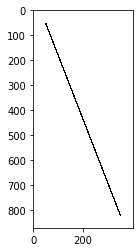

In [43]:
im, draw, start = draw_background(1.2,300)
plt.imshow(im)
print(start)

In [44]:
def draw_trajectory(draw, start, pos, theta, cube_len=30,fill=(255,0,0)):
#     theta = theta * np.pi/180
    cx = start[0]+pos*np.cos(theta)
    cy = start[1]+pos*np.sin(theta)
    cx += np.sin(theta)*cube_len/2
    cy -= np.cos(theta)*cube_len/2
    x_ll = cx-np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ll = cy+np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    x_lr = cx+np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_lr = cy+np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)

    x_ul = cx+np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ul = cy-np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    x_ur = cx-np.sin(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    y_ur = cy-np.cos(45 * np.pi/180 - theta)*cube_len/np.sqrt(2)
    draw.polygon([(x_ul, y_ul),(x_lr, y_lr),(x_ll, y_ll),(x_ur, y_ur)],fill=fill)
        

In [45]:
def draw_cube(folder, trajectory, theta, scale=1):
    images=[]
    for i in range(trajectory.shape[1]):
        print(i, trajectory[0][i], trajectory[1][i])
        fig=plt.figure(figsize=(8, 8))         
        pos_1 = trajectory[0][i]*scale                      
        im, draw, start = draw_background(theta,300)
        draw_trajectory(draw, start, pos_1, theta, cube_len=30)
        ax_1= fig.add_subplot(121)
        ax_1.title.set_text('Ground truth')
        plt.imshow(im)
        pos_2 = trajectory[1][i]*scale                          
        im_2, draw, start = draw_background(theta,300)
        draw_trajectory(draw, start, pos_2, theta, cube_len=30)
        ax_2 = fig.add_subplot(122)
        ax_2.title.set_text('Prediction')
        plt.imshow(im_2)                          
        fig.savefig('plot.png') 
        images.append(Image.open('plot.png'))
    images[0].save('_'.join([folder, str(batch_ind), str(datapoint_ind),'cube.gif']),
                    save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)



In [68]:
def draw_cube_stack(folder, trajectory, theta, slope_len, scale=None, suffix='' ):
    if scale is None:
        scale = (slope_len/np.cos(theta))/(max(trajectory[0][-1], trajectory[1][-1])+20)
    print('scale is ', scale)
    images=[]
    for i in range(trajectory.shape[1]):
        print(i, trajectory[0][i], trajectory[1][i])
        fig=plt.figure(figsize=(8, 8))         
        pos_1 = trajectory[0][i]*scale               
        im, draw, start = draw_background(theta, slope_len)
        draw_trajectory(draw, start, pos_1, theta, cube_len=30, fill='hsl(%d, %d%%, %d%%)' % (180,100,50))             
        pos_2 = trajectory[1][i]*scale                 
        draw_trajectory(draw, start, pos_2, theta, cube_len=30, fill='hsl(%d, %d%%, %d%%)' % (0,100,50)) 
        fig.suptitle('Blue ground truth, red prediction.')
        plt.imshow(im)                          
        fig.savefig('plot.png') 
        images.append(Image.open('plot.png'))
    images[0].save('_'.join([folder, suffix, str(batch_ind), str(datapoint_ind),'cube_stack.gif']),
                    save_all=True, append_images=images[1:], optimize=False, duration=400, loop=0)




In [106]:
feat = np.load('data/datasets/feat_train_'+args.suffix + '.npy')
feat=feat[:,:,0,0]

In [123]:
x=feat[np.where(feat[:,2] == 10.0000)]
set(x[np.where(x[:,3]>3)][:,0])

{1.0, 2.0, 3.0, 100.0, 200.0}

In [102]:
args.suffix = 'valid_causal_vel_x0s_extrapolation_20_40%'
args.gt_A=True
folder='exp2020-08-17T00:36:32.387949_train-bs_128_suffix_causal_vel_x0s_val-suffix_causal_vel_interpolation_input-atoms_6_dims_9_decoder-hidden_512_gt-A'
path='logs/'+folder
loss, truth, pred, condition = load_predict(args,path+'/best_decoder.pt', stop_ind=50)

loading valid_causal_vel_x0s_extrapolation_20_40%
batch_size 1
Nll tensor(9337.6475, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([ 1.0000,  3.0000,  0.7800,  1.5000, 12.0000, -1.0000], device='cuda:0')
Velocity 0 tensor([  9.2347,  18.4695,  27.7042,  36.9389,  46.1737,  55.4084,  64.6432,
         73.8779,  83.1126,  92.3474, 101.5821, 110.8168, 120.0516, 129.2863,
        138.5210, 147.7558, 156.9905, 166.2253], device='cuda:0') 
 tensor([  8.9352,  17.8618,  26.8132,  35.7785,  44.7596,  53.7180,  62.6708,
         71.6184,  80.5627,  89.5036,  98.3958, 107.1928, 115.8331, 124.2274,
        132.3857, 140.2388, 147.7482, 154.8966], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 0 tensor([   3.6174,   17.4695,   40.5563,   72.8779,  114.4342,  165.2253,
         225.2510,  294.5115,  373.0069,  460.7368,  557.7016,  663.9011,
         779.3351,  904.0042, 1037.9077, 1181.0461, 1333.4194, 1495.0273],
       device='cuda:0') 

batch_size 1
Nll tensor(26023.9336, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([ 2.0000,  7.0000,  0.7400,  0.2400,  0.2000, -1.0000], device='cuda:0')
Velocity 8 tensor([ -4.7147,  -9.4293, -14.1440, -18.8586, -23.5733, -28.2879, -33.0026,
        -37.7173, -42.4319, -47.1466, -51.8612, -56.5759, -61.2905, -66.0052,
        -70.7199, -75.4345, -80.1492, -84.8638], device='cuda:0') 
 tensor([-0.1312, -0.2594, -0.3823, -0.4976, -0.6045, -0.7018, -0.7890, -0.8645,
        -0.9279, -0.9780, -1.0145, -1.0375, -1.0470, -1.0432, -1.0266, -0.9972,
        -0.9519, -0.8893], device='cuda:0', grad_fn=<SelectBackward>)
Position 8 tensor([  -3.3574,  -10.4293,  -22.2159,  -38.7172,  -59.9332,  -85.8638,
        -116.5090, -151.8690, -191.9435, -236.7328, -286.2368, -340.4553,
        -399.3885, -463.0364, -531.3989, -604.4761, -682.2679, -764.7745],
       device='cuda:0') 
 tensor([ 0.5499,  2.2432,  4.0735,  6.0585,  8.2132, 10.5359, 13.0321, 1

batch_size 1
Nll tensor(17537.6504, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 15 tensor([ 3.0000,  7.0000,  0.6800,  0.3500, 12.0000, 24.0000], device='cuda:0')
Velocity 15 tensor([ -2.8996,  -5.7992,  -8.6987, -11.5983, -14.4979, -17.3975, -20.2971,
        -23.1966, -26.0962, -28.9958, -31.8954, -34.7950, -37.6946, -40.5941,
        -43.4937, -46.3933, -49.2929, -52.1925], device='cuda:0') 
 tensor([ 0.5309,  1.0739,  1.6292,  2.1982,  2.7803,  3.3761,  3.9864,  4.6112,
         5.2502,  5.9036,  6.5715,  7.2550,  7.9536,  8.6669,  9.3947, 10.1369,
        10.8940, 11.6649], device='cuda:0', grad_fn=<SelectBackward>)
Position 15 tensor([  22.5502,   18.2009,   10.9519,    0.8033,  -12.2447,  -28.1924,
         -47.0397,  -68.7866,  -93.4330, -120.9791, -151.4247, -184.7698,
        -221.0146, -260.1589, -302.2029, -347.1464, -394.9894, -445.7321],
       device='cuda:0') 
 tensor([ 32.8212,  41.9070,  51.3047,  60.9317,  70.7975,  80.9291,  

Position 22 tensor([  22.0900,   16.3597,    6.8093,   -6.5613,  -23.7521,  -44.7630,
         -69.5940,  -98.2453, -130.7167, -167.0082, -207.1201, -251.0519,
        -298.8040, -350.3763, -405.7687, -464.9813, -528.0140, -594.8670],
       device='cuda:0') 
 tensor([ 28.4434,  33.0684,  37.8903,  42.9065,  48.1168,  53.5250,  59.1497,
         65.0078,  71.0486,  77.2469,  83.5849,  90.0756,  96.7188, 103.5173,
        110.4822, 117.6035, 124.8769, 132.2958], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(9245.7891, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([ 2.0000,  7.0000,  0.7800,  1.4500,  0.2000, 26.0000], device='cuda:0')
Velocity 23 tensor([  8.8075,  17.6149,  26.4224,  35.2299,  44.0373,  52.8448,  61.6523,
         70.4597,  79.2672,  88.0746,  96.8821, 105.6896, 114.4970, 123.3045,
        132.1120, 140.9194, 149.7269, 158.5344], device='cuda:0') 
 tensor([  8.6795,  17.3488,  26.0435,  34.757

       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(17553.1367, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 30 tensor([10.0000,  3.0000,  0.6800,  0.3500, 13.0000, -1.0000], device='cuda:0')
Velocity 30 tensor([ -2.8996,  -5.7992,  -8.6987, -11.5983, -14.4979, -17.3975, -20.2971,
        -23.1966, -26.0962, -28.9958, -31.8954, -34.7950, -37.6946, -40.5941,
        -43.4937, -46.3933, -49.2929, -52.1925], device='cuda:0') 
 tensor([ 0.5309,  1.0739,  1.6292,  2.1981,  2.7803,  3.3760,  3.9863,  4.6111,
         5.2502,  5.9035,  6.5715,  7.2549,  7.9536,  8.6669,  9.3947, 10.1368,
        10.8940, 11.6648], device='cuda:0', grad_fn=<SelectBackward>)
Position 30 tensor([  -2.4498,   -6.7991,  -14.0480,  -24.1966,  -37.2448,  -53.1924,
         -72.0397,  -93.7866, -118.4330, -145.9791, -176.4246, -209.7698,
        -246.0146, -285.1589, -327.2029, -372.1464, -419.9895, -470.7321],
       device='cuda:0') 
 tensor([  7.8624,  

batch_size 1
Nll tensor(10448.4668, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 40 tensor([ 2.0000,  3.0000,  0.6800,  1.5000,  0.2000, 24.0000], device='cuda:0')
Velocity 40 tensor([  9.3041,  18.6081,  27.9122,  37.2162,  46.5203,  55.8243,  65.1284,
         74.4325,  83.7365,  93.0406, 102.3447, 111.6487, 120.9528, 130.2568,
        139.5609, 148.8649, 158.1690, 167.4731], device='cuda:0') 
 tensor([  9.2328,  18.4498,  27.6674,  36.8947,  46.1219,  55.3161,  64.4935,
         73.6610,  82.8614,  92.0932, 101.3025, 110.4535, 119.4471, 128.2110,
        136.7165, 144.8897, 152.6653, 160.0804], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 40 tensor([  28.6520,   42.6082,   65.8683,   98.4325,  140.3008,  191.4731,
         251.9494,  321.7299,  400.8145,  489.2029,  586.8956,  693.8923,
         810.1929,  935.7978, 1070.7068, 1214.9194, 1368.4365, 1531.2576],
       device='cuda:0') 
 tensor([ 104.7436,  189.2328,  276.8926,  36

        132.8205, 141.6752, 150.5299, 159.3846], device='cuda:0') 
 tensor([  8.7815,  17.5577,  26.3414,  35.1547,  43.9736,  52.7718,  61.5285,
         70.2657,  79.0260,  87.7909,  96.5245, 105.1683, 113.6862, 121.9846,
        130.0629, 137.8569, 145.3074, 152.4473], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 47 tensor([  30.4274,   43.7095,   65.8462,   96.8376,  136.6838,  185.3846,
         242.9402,  309.3504,  384.6154,  468.7352,  561.7094,  663.5386,
         774.2224,  893.7608, 1022.1540, 1159.4019, 1305.5044, 1460.4617],
       device='cuda:0') 
 tensor([ 103.7167,  184.8127,  268.4776,  355.0154,  444.8356,  537.5618,
         632.7054,  730.4686,  830.0997,  930.2636, 1028.3252, 1122.3442,
        1210.4055, 1291.9050, 1365.1958, 1430.9880, 1490.1416, 1543.0532],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(28008.9258, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 48 tensor([ 2.0000,  7

scale is  2.21843687484272
0 24.550232 34.818054
1 20.200806 43.905457
2 12.951904 53.29773
3 2.8033447 62.918396
4 -10.244751 72.78009
5 -26.192383 82.907776
6 -45.039734 93.24646
7 -66.78656 103.79724
8 -91.43298 114.56494
9 -118.979004 125.52606
10 -149.42462 136.68286
11 -182.76984 148.04211
12 -219.01453 159.5918
13 -258.15894 171.31232
14 -300.20288 183.19824
15 -345.14636 195.2539
16 -392.98947 207.50934
17 -443.73212 219.93024


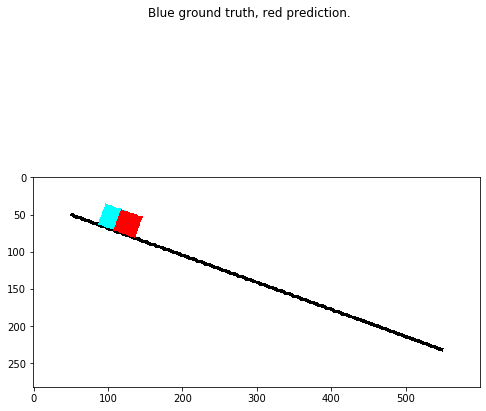

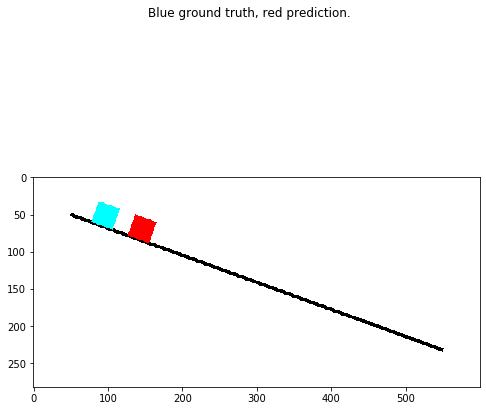

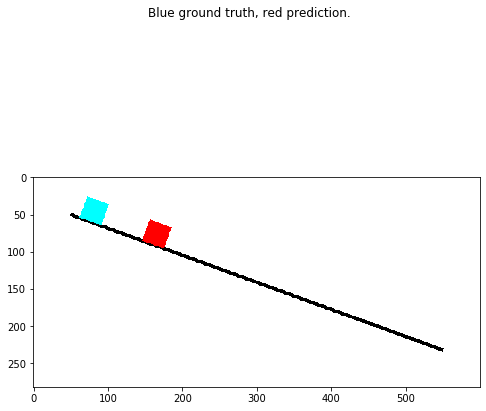

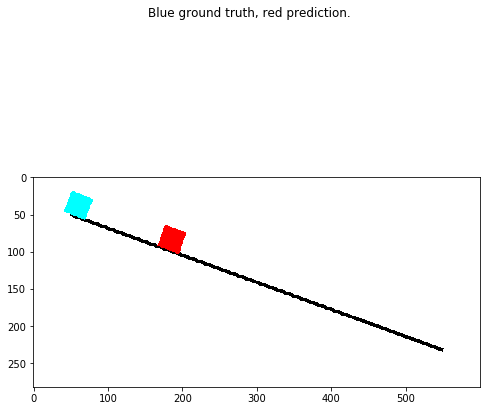

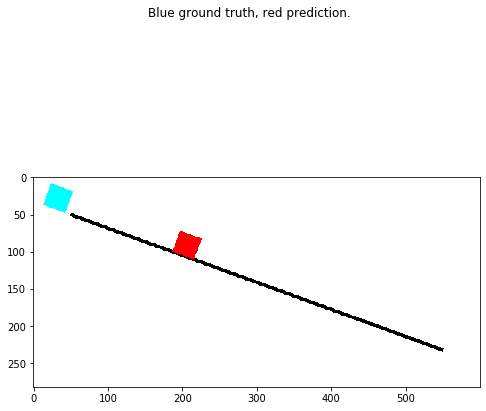

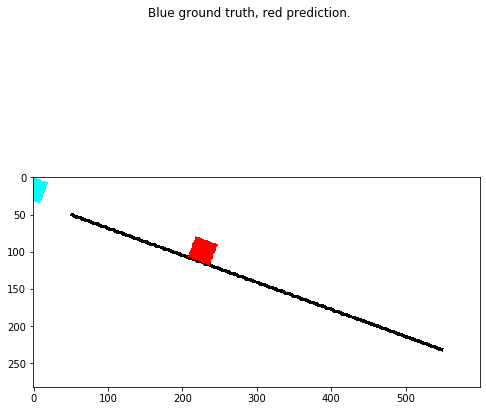

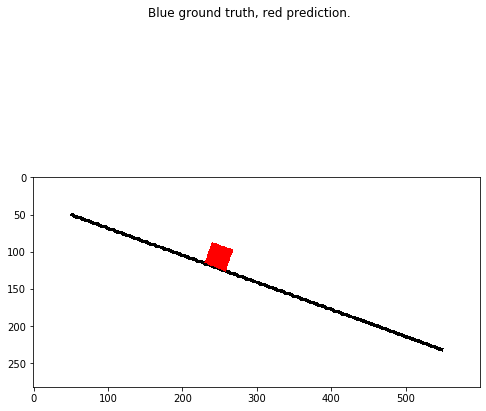

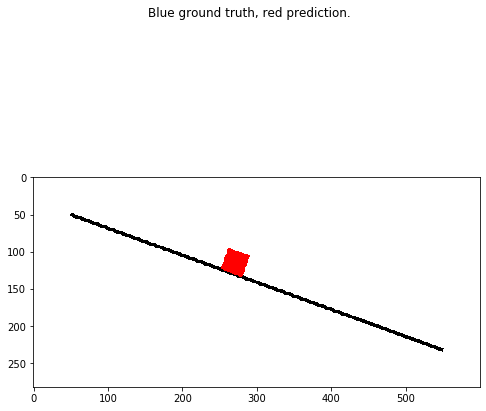

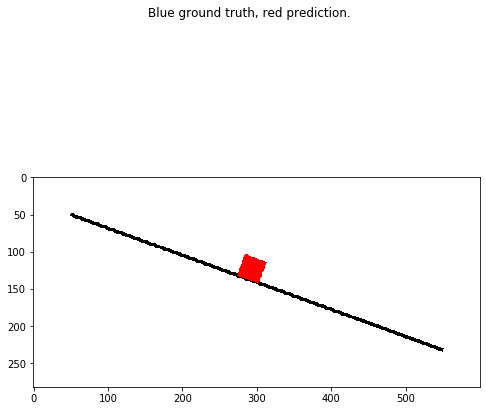

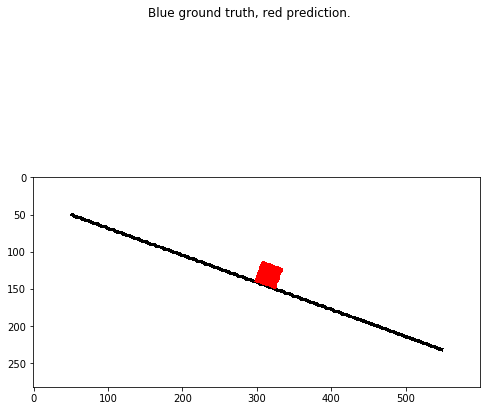

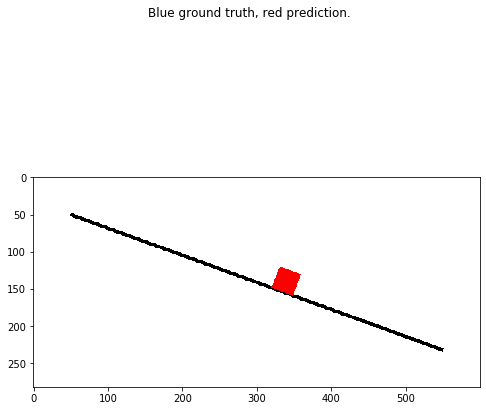

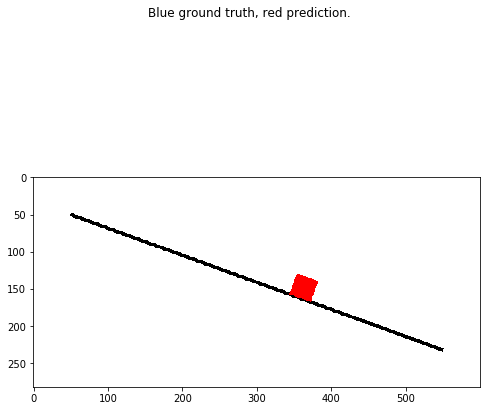

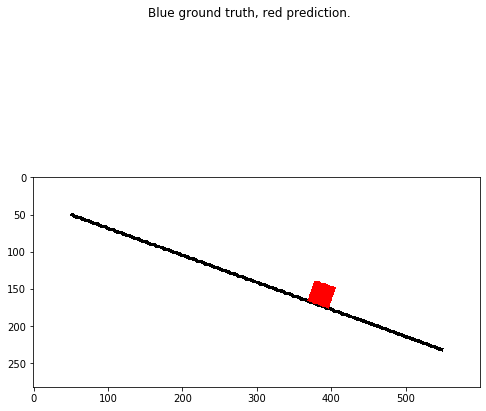

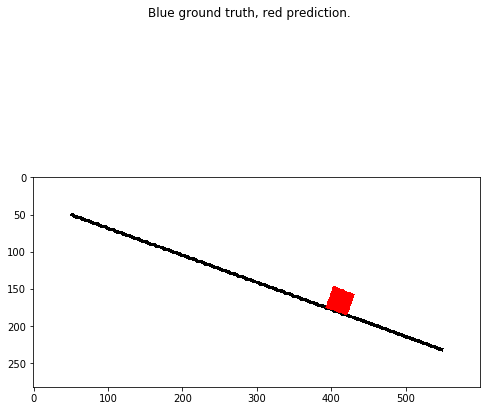

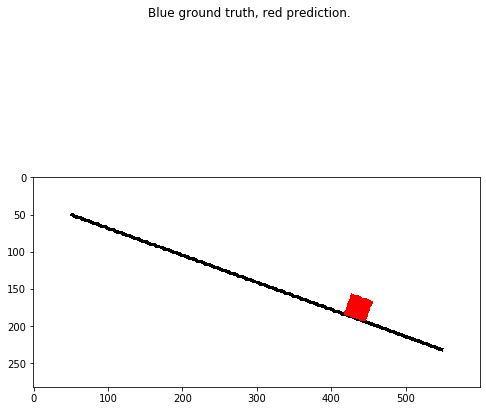

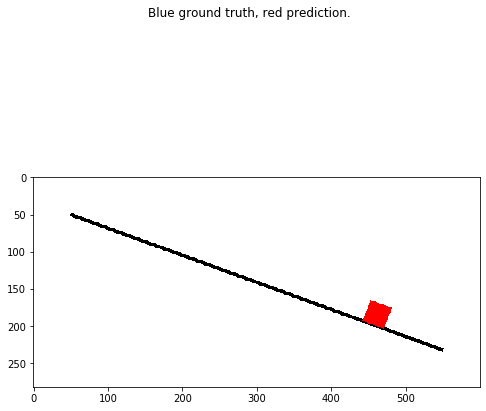

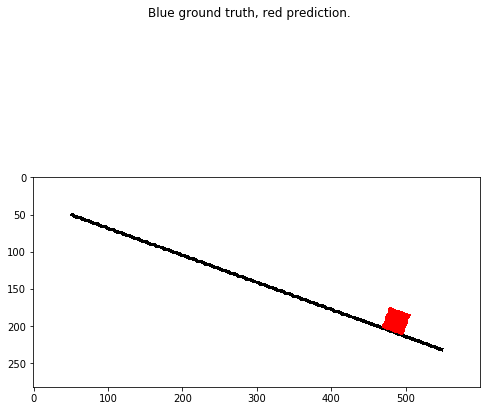

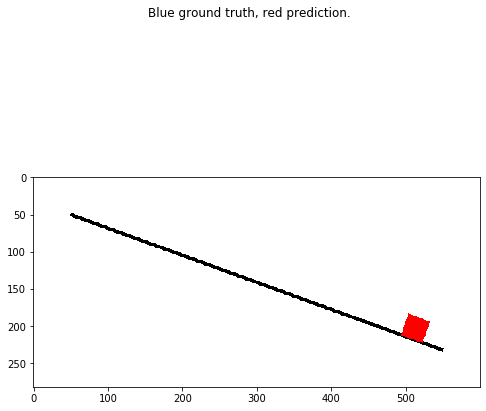

In [104]:
batch_ind = 49
datapoint_ind = 0
trajectory=np.array([truth[batch_ind][datapoint_ind, -1, :, 0].detach().cpu().numpy(),pred[batch_ind][datapoint_ind, -1, :, 0].detach().cpu().numpy()])
theta=condition[batch_ind][datapoint_ind][3].item()
# draw_cube(folder, trajectory, theta)
draw_cube_stack(folder, trajectory, theta, 500, suffix='extrapolation2040')

In [28]:
x =  np.load('data/datasets/feat_train_causal_vel_x0s.npy')
for i in range(6):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{1.0, 2.0, 3.0, 6.0, 9.0, 10.0}
{1.0, 3.0, 5.0, 7.0, 9.0, 11.0}
{0.3, 0.56, 0.1, 0.22, 0.28, 0.01}
{0.7853981633974483, 1.0471975511965976, 0.9817477042468103, 1.2566370614359172, 0.6283185307179586, 0.5235987755982988}
{2.0, 3.5, 5.0, 8.0, 9.0, 10.0}
{3.0, 5.0, 10.0, 11.0, 17.0, 20.0}
4.0
3.0
3.2
2.5
5.0
6.0


In [45]:
y =  n
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(y[:,i,0,0]))
for i in set(y[:,3,0,0]):
    print(np.pi/i)

{8.0, 4.0, 5.0, 7.0}
{8.0, 2.0, 4.0, 6.0}
{0.18, 0.26, 0.48, 0.5}
{0.8490790955648089, 0.6981317007977318, 1.1635528346628863, 0.5711986642890533}
{2.7, 3.6, 2.3, 7.0}
3.7
4.5
2.7
5.5


In [37]:
x =  np.load('data/datasets/feat_train_causal_vel_grouped_46656_x0s.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{0.2945703805744371, 2.1746018390150246, 4.709178831461223, 10.707323896632925, 17.90109133492352, 18.443241651557855}
{6.444157225960378, 6.473557830761198, 8.422289279168496, 9.708923257605571, 13.304413652313778, 17.987940431277146}
{0.03236727517783888, 0.5424096630692735, 0.38226477515080215, 0.8029196095360561, 0.05515940346945036, 0.21097059217164793}
{0.1778569832714908, 1.2785271587503566, 0.17722706684139167, 0.4114338900496611, 0.018927094208086193, 1.3492917908739654}
{1.6351224561247935, 4.562630947312978, 6.015489417044664, 18.428300115083104, 19.78184679271364, 19.748196643271065}
17.663589001699705
2.457196651700706
17.726370523309193
7.635716769006548
165.98388632987388
2.328327108219428


In [38]:
x =  np.load('data/datasets/feat_valid_causal_vel_grouped_46656_x0s.npy')
for i in range(5):
    #[shapes,colors,mus,thetas,masses,v0s]
    print(set(x[:,i,0,0]))
for i in set(x[:,3,0,0]):
    print(np.pi/i)

{16.397163938436826, 8.264018696323616, 16.475188651410427, 17.52535310413255}
{16.04341124848951, 1.0894901564470927, 14.372744731283886, 14.728132876228779}
{0.8928601514360016, 0.3319798053011772, 0.8212291230578318, 0.0416966257252499}
{0.16148501990395192, 0.8925780963093604, 0.7947260432892325, 0.6282111428349815}
{8.762828522177482, 12.450388643921803, 6.708156985466585, 14.717642126973804}
19.45439060204067
3.519683786303605
3.9530510924082582
5.000854711701646


In [30]:
folder='exp2020-08-15T22:33:50.224932_train-bs_128_suffix_causal_vel_x0s_more_val-suffix_causal_vel_interpolation_gt-A_dims_9_input-atoms_6'
path='logs/'+folder
loss, truth, pred, condition = load_predict(path+'/best_decoder.pt', stop_ind=50)

batch_size 1
Nll tensor(10691.9531, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 0 tensor([10.0000,  1.0000,  0.6500,  1.4280,  1.0000,  2.0000], device='cuda:0')
Velocity 0 tensor([  8.7937,  17.5874,  26.3811,  35.1748,  43.9685,  52.7622,  61.5559,
         70.3496,  79.1433,  87.9370,  96.7308, 105.5244, 114.3181, 123.1119,
        131.9056, 140.6993, 149.4930, 158.2867], device='cuda:0') 
 tensor([  6.0115,  12.0341,  18.0552,  24.0750,  30.0732,  36.0185,  41.9079,
         47.7677,  53.6366,  59.5324,  65.4754,  71.4799,  77.5415,  83.6474,
         89.8177,  96.0596, 102.3768, 108.7521], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 0 tensor([   6.3969,   19.5874,   41.5717,   72.3497,  111.9213,  160.2867,
         217.4458,  283.3985,  358.1450,  441.6852,  534.0191,  635.1467,
         745.0680,  863.7830,  991.2917, 1127.5941, 1272.6903, 1426.5802],
       device='cuda:0') 
 tensor([  16.6206,   36.0990,   61.4060,   93.2

batch_size 1
Nll tensor(1237.2451, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 8 tensor([ 1.0000,  1.0000,  0.6500,  0.4987, 11.0000, 23.0000], device='cuda:0')
Velocity 8 tensor([ -0.9074,  -1.8148,  -2.7221,  -3.6295,  -4.5369,  -5.4443,  -6.3517,
         -7.2591,  -8.1664,  -9.0738,  -9.9812, -10.8886, -11.7960, -12.7034,
        -13.6107, -14.5181, -15.4255, -16.3329], device='cuda:0') 
 tensor([ -0.5506,  -1.1159,  -1.6958,  -2.2896,  -2.8969,  -3.5184,  -4.1536,
         -4.8017,  -5.4626,  -6.1366,  -6.8235,  -7.5239,  -8.2369,  -8.9623,
         -9.7002, -10.4506, -11.2136, -11.9893], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 8 tensor([  22.5463,   21.1852,   18.9168,   15.7410,   11.6577,    6.6671,
           0.7691,   -6.0363,  -13.7490,  -22.3691,  -31.8966,  -42.3316,
         -53.6738,  -65.9235,  -79.0805,  -93.1449, -108.1168, -123.9960],
       device='cuda:0') 
 tensor([ 23.4080,  23.4976,  23.2710,  22.7199, 

       grad_fn=<SelectBackward>)
Position 15 tensor([   6.9000,   21.6000,   46.1000,   80.4000,  124.5000,  178.4000,
         242.1000,  315.6000,  398.9000,  491.9999,  594.9000,  707.6000,
         830.1000,  962.4000, 1104.5000, 1256.4000, 1418.1000, 1589.6000],
       device='cuda:0') 
 tensor([  17.1039,   39.1605,   70.7656,  113.2485,  166.9958,  232.4138,
         309.7836,  398.1749,  498.3140,  609.7523,  731.8871,  864.5025,
        1007.5696, 1161.0532, 1323.1835, 1488.3313, 1651.6237, 1810.1699],
       device='cuda:0', grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(4126.7295, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 16 tensor([1.0000e+00, 5.0000e+00, 9.9999e-04, 1.4280e+00, 1.1000e+01, 2.0000e+00],
       device='cuda:0')
Velocity 16 tensor([  9.6989,  19.3977,  29.0966,  38.7954,  48.4943,  58.1931,  67.8920,
         77.5908,  87.2897,  96.9885, 106.6874, 116.3863, 126.0851, 135.7840,
        145.4828, 155.1817, 164.8805,

       device='cuda:0') 
 tensor([  0.5327,   0.7484,   0.6506,   0.2325,  -0.5131,  -1.5853,  -2.9936,
         -4.7354,  -6.8144,  -9.2018, -11.8854, -14.8592, -18.1079, -21.6242,
        -25.4098, -29.4704, -33.7994, -38.3964], device='cuda:0',
       grad_fn=<SelectBackward>)
batch_size 1
Nll tensor(3790.3040, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 23 tensor([3.0000e+00, 3.0000e+00, 5.0000e-03, 1.5708e+00, 1.4000e+01, 5.0000e-01],
       device='cuda:0')
Velocity 23 tensor([  9.8000,  19.6000,  29.4000,  39.2000,  49.0000,  58.8000,  68.6000,
         78.4000,  88.2000,  98.0000, 107.8000, 117.6000, 127.4000, 137.2000,
        147.0000, 156.8000, 166.6000, 176.4000], device='cuda:0') 
 tensor([  8.8793,  17.8198,  26.8183,  35.9111,  45.1317,  54.5175,  64.0618,
         73.7293,  83.4874,  93.3562, 103.3481, 113.5335, 123.8823, 134.3536,
        144.9086, 155.5385, 166.0821, 176.4561], device='cuda:0',
       grad_fn=<SelectBackward>)


batch_size 1
Nll tensor(4585.1943, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 30 tensor([1.0000e+00, 1.0000e+00, 9.9999e-04, 1.4280e+00, 1.4000e+01, 2.3000e+01],
       device='cuda:0')
Velocity 30 tensor([  9.6989,  19.3977,  29.0966,  38.7954,  48.4943,  58.1931,  67.8920,
         77.5908,  87.2897,  96.9885, 106.6874, 116.3863, 126.0851, 135.7840,
        145.4828, 155.1817, 164.8805, 174.5794], device='cuda:0') 
 tensor([  8.5356,  17.1222,  25.7744,  34.5243,  43.4037,  52.4096,  61.5143,
         70.7338,  80.0489,  89.5097,  99.1262, 108.8937, 118.8193, 128.8447,
        138.9294, 149.0573, 159.1582, 169.1223], device='cuda:0',
       grad_fn=<SelectBackward>)
Position 30 tensor([  27.8494,   42.3977,   66.6449,  100.5908,  144.2357,  197.5794,
         260.6219,  333.3634,  415.8036,  507.9427,  609.7807,  721.3176,
         842.5533,  973.4879, 1114.1212, 1264.4535, 1424.4845, 1594.2145],
       device='cuda:0') 
 tensor([  39.8483,  

Nll tensor(3536.1455, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 37 tensor([3.0000e+00, 5.0000e+00, 5.0000e-03, 5.1502e-01, 1.0000e+00, 5.0000e-01],
       device='cuda:0')
Velocity 37 tensor([ 4.7843,  9.5687, 14.3530, 19.1373, 23.9216, 28.7060, 33.4903, 38.2746,
        43.0589, 47.8433, 52.6276, 57.4119, 62.1963, 66.9806, 71.7649, 76.5492,
        81.3336, 86.1179], device='cuda:0') 
 tensor([ 3.6041,  7.2113, 10.8143, 14.4197, 18.0326, 21.6499, 25.2773, 28.9250,
        32.5815, 36.2393, 39.8981, 43.5583, 47.2167, 50.8731, 54.5210, 58.1637,
        61.8006, 65.4175], device='cuda:0', grad_fn=<SelectBackward>)
Position 37 tensor([  2.8921,  10.0686,  22.0295,  38.7746,  60.3041,  86.6179, 117.7160,
        153.5985, 194.2652, 239.7164, 289.9518, 344.9715, 404.7756, 469.3641,
        538.7368, 612.8939, 691.8353, 775.5609], device='cuda:0') 
 tensor([ 11.4000,  25.0410,  41.6816,  61.7808,  85.6834, 113.4747, 145.3488,
        181.4412, 221.7

batch_size 1
Nll tensor(1131.2798, device='cuda:0', grad_fn=<DivBackward0>)
Setup [shapes,colors,mus,thetas,masses,v0s] 45 tensor([1.0000, 7.0000, 0.6000, 0.4987, 1.0000, 0.0000], device='cuda:0')
Velocity 45 tensor([-0.4771, -0.9541, -1.4312, -1.9082, -2.3853, -2.8623, -3.3394, -3.8164,
        -4.2935, -4.7705, -5.2476, -5.7246, -6.2017, -6.6788, -7.1558, -7.6329,
        -8.1099, -8.5870], device='cuda:0') 
 tensor([-0.3520, -0.7245, -1.1174, -1.5290, -1.9583, -2.4052, -2.8692, -3.3486,
        -3.8424, -4.3497, -4.8701, -5.4041, -5.9511, -6.5109, -7.0837, -7.6696,
        -8.2684, -8.8801], device='cuda:0', grad_fn=<SelectBackward>)
Position 45 tensor([ -0.2385,  -0.9541,  -2.1467,  -3.8164,  -5.9632,  -8.5870, -11.6879,
        -15.2657, -19.3207, -23.8527, -28.8618, -34.3479, -40.3110, -46.7513,
        -53.6686, -61.0629, -68.9343, -77.2827], device='cuda:0') 
 tensor([ 2.0694,  3.8924,  5.4621,  6.7816,  7.8494,  8.6621,  9.2182,  9.5119,
         9.5313,  9.2688,  8.7195,  7.8

2.4000000953674316